# Keyword network evolution
In this notebook, we will generate data regarding different aspects related to keyword network evolution for both $D_{sas}$ and $D_{obs}$ dataset:<br>
1. Co-word network evolution <br>
2. Keyword type effect on network evolution <br>
3. Inter-year node pairs characteristics

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import graph as gr
import utils as ut
import feature_selection as fs
import classification as cl
import os.path
import matplotlib.pyplot as plt
from pprint import pprint
import importlib
import community
import seaborn as sns
from gensim.models import KeyedVectors
from pyemd import emd
from gensim import corpora
from nltk.corpus import stopwords
from gensim.matutils import softcossim
import copy
import itertools
from keras.models import Model, Sequential
from keras.layers import LSTM, Dense
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Dense, Dropout, Activation, Reshape
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, roc_auc_score
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.models import load_model
import pickle

Using Theano backend.
C:\Users\faisal\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
importlib.reload(gr)

<module 'graph' from 'C:\\Users\\faisal\\PycharmProjects\\linkPrediction\\graph.py'>

#### filepath

In [11]:
select_domain  = 1 #0:apnea ro 1:obesity
domain = ['apnea','obesity']
root = '../linkPrediction/'
filepath=[['dataset/apnea-all,3.csv',
         'dataset/apnea-distinct_keyword.csv'],
        ['dataset/obesity-all,3.csv',
         'dataset/obesity-distinct_keyword.csv']]
graphpath=root+'graphs/'+domain[select_domain]
datapath=root+'dataframes/'+domain[select_domain]
modelpath=root+'models/'+domain[select_domain]
column_split=['keyword','author_name','affiliation_1','affiliation_2','country']
#time=[parent_start_year, train_start_year, test_start_year, total_test_period_in_year, total_year_in_each_iteration]
times=[2007,2008,2015,1,1,200]
time=[2007,2008,2015,1,1,200]
df, key_list = ut.load_dataset(filepath[select_domain], column_split)

#### Dynamic graph building

In [ ]:
for tout in range(1991,2008,8):
    time =  [tout,tout+1,tout+8,1,1,20]
    gr.dynamic_train_test_graph_build(df, key_list, graphpath, time)

272
../linkPrediction/graphs/apnea\train_graph_1992.gpickle saved, nodes: 56 edges: 41
../linkPrediction/graphs/apnea\train_graph_1993.gpickle saved, nodes: 70 edges: 56
../linkPrediction/graphs/apnea\train_graph_1994.gpickle saved, nodes: 76 edges: 59


In [12]:
g_train, g_test, g_parent, g_train_static, g_test_static = gr.graph_load(graphpath, times)


../linkPrediction/graphs/obesity\train_graph_2008.gpickle loaded, nodes: 2356 edges: 10282
../linkPrediction/graphs/obesity\train_graph_2009.gpickle loaded, nodes: 2092 edges: 10477
../linkPrediction/graphs/obesity\train_graph_2010.gpickle loaded, nodes: 2298 edges: 12001
../linkPrediction/graphs/obesity\train_graph_2011.gpickle loaded, nodes: 2408 edges: 14271
../linkPrediction/graphs/obesity\train_graph_2012.gpickle loaded, nodes: 2579 edges: 16158
../linkPrediction/graphs/obesity\train_graph_2013.gpickle loaded, nodes: 2582 edges: 15851
../linkPrediction/graphs/obesity\train_graph_2014.gpickle loaded, nodes: 3217 edges: 18238
../linkPrediction/graphs/obesity\test_graph_2015.gpickle loaded, nodes: 4027 edges: 21650
../linkPrediction/graphs/obesity\parent_graph_2007-2008.gpickle loaded, nodes: 2109 edges: 9569
../linkPrediction/graphs/obesity\train_graph_2008-2015.gpickle loaded, nodes: 4025 edges: 50405
../linkPrediction/graphs/obesity\test_graph_2015-2016.gpickle loaded, nodes: 4027

In [124]:
importlib.reload(fs)
importlib.reload(cl)

train_data={}
train_data[2015] = pd.DataFrame({'row_name': train_ed, 'label': label})

g_train[2015]=g_test[2015]
time=[2014,2015,2016,1,1,20]
node_feature, train_data = fs.dynamic_graph_feature_set(df, key_list, train_data, g_train[2014], g_train, g_train_static, time)
time=[2007,2008,2015,1,1,200]
ut.save_data(train_data, datapath, domain[select_domain], "test_data", time)
ut.save_data(node_feature, datapath, domain[select_domain], "test_node", time)

../linkPrediction/dataframes/obesity\obesity-test_data_2008-2015.pkl
../linkPrediction/dataframes/obesity\obesity-test_node_2008-2015.pkl


In [122]:
edge_list = ut.load_data(datapath, domain[select_domain], "edge_list", time)
edge_set = set(edge_list)
edges = list(g_test[2015].edges())
non_edges =  list(nx.non_edges(g_test[2015]))
r_edges = [(b, a) for a, b in edges]
r_non_edges = [(b, a) for a, b in non_edges]
test_edges = []
label = []
train_ed=[]
ins = set(edges).intersection(edge_set)
train_ed.extend(ins)
label.extend([1]*len(ins))
ins = set(r_edges).intersection(edge_set)
train_ed.extend(ins)
label.extend([1]*len(ins))
ins = set(non_edges).intersection(edge_set)
train_ed.extend(ins)
label.extend([0]*len(ins))
ins = set(r_non_edges).intersection(edge_set)
train_ed.extend(ins)
label.extend([0]*len(ins))

../linkPrediction/dataframes/obesity


In [123]:
len(train_ed)

134398

In [ ]:
time=[2014,2015,2016,1,1,20]
test_data=[]
test_data.append(ut.load_data('../linkPrediction/dataframes/apnea','apnea', "test_data", time))
test_data.append(ut.load_data('../linkPrediction/dataframes/obesity','obesity', "test_data", time))

fig, axs = plt.subplots(2,1,figsize=(11,8))
for i,data in enumerate(test_data):
    train_data={}
    train_data[2015]=data
    e_gpgp1 = train_data[year].loc[(train_data[year]['label']==1) & (train_data[year]['type']==400),['type']].count()
    e_gpgp0 = train_data[year].loc[(train_data[year]['label']==0) & (train_data[year]['type']==400),['type']].count()
    e_gpp1 = train_data[year].loc[(train_data[year]['label']==1) & (train_data[year]['type']==100),['type']].count()
    e_gpp0 = train_data[year].loc[(train_data[year]['label']==0) & (train_data[year]['type']==100),['type']].count()
    e_gpc1 = train_data[year].loc[(train_data[year]['label']==1) & (train_data[year]['type']==60),['type']].count()
    e_gpc0 = train_data[year].loc[(train_data[year]['label']==0) & (train_data[year]['type']==60),['type']].count()
    e_gpg1 = train_data[year].loc[(train_data[year]['label']==1) & (train_data[year]['type']==20),['type']].count()
    e_gpg0 = train_data[year].loc[(train_data[year]['label']==0) & (train_data[year]['type']==20),['type']].count()
    e_pc1  = train_data[year].loc[(train_data[year]['label']==1) & (train_data[year]['type']==15),['type']].count()
    e_pg1  = train_data[year].loc[(train_data[year]['label']==1) & (train_data[year]['type']==5),['type']].count()
    e_cg1  = train_data[year].loc[(train_data[year]['label']==1) & (train_data[year]['type']==3),['type']].count()
    total  = train_data[year].loc[train_data[year]['label']==1,['type']].count()
    #tot_gp = e_gpgp1[0] + e_gpp1[0] + e_gpc1[0]+ e_gpg1[0]+e_pc1[0]+e_pg1[0]+e_cg1[0]
    ratgpgp = e_gpgp1[0]*100/total[0]
    ratgpp = e_gpp1[0]*100/total[0]
    ratgpc = e_gpc1[0]*100/total[0]
    ratgpg = e_gpg1[0]*100/total[0]
    ratpc = e_pc1[0]*100/total[0]
    ratpg = e_pg1[0]*100/total[0]
    ratgc = e_gc1[0]*100/total[0]
    rat=[ratgpgp,ratgpp,ratgpc,ratgpg,ratpc,ratpg,ratgc]

In [53]:
from collections import Iterable


def flatten(items):
    """Yield items from any nested iterable; see Reference."""
    for x in items:
        if isinstance(x, Iterable) and not isinstance(x, (str, bytes)):
            for sub_x in flatten(x):
                yield sub_x
        else:
            yield x

In [284]:
def key_find(row):
    keys = []
    for label in row:
        keys.append(gr.node_key_find(key_list, label))
    return keys
        
df['key']=df.apply(lambda row: key_find(row['keyword']),axis=1)
#save dataset with key
ut.save_data(df, datapath, domain[select_domain], "dataset", time)

../linkPrediction/dataframes/apnea\apnea-dataset_2008-2015.pkl


In [849]:
df = ut.load_data(datapath, domain[select_domain], "dataset", time)

../linkPrediction/dataframes/obesity


In [285]:
graphs = {}
for t in range(2007,2016,1):
    g=nx.Graph()
    ###nodes
    nodes = list(df[(df['art_year'] >= t) & (df['art_year'] < t+1)]['key'])
    nodes = set(flatten(nodes))
    g.add_nodes_from(nodes)
    ###edges
    g_df = df[(df['art_year'] >= t) & (df['art_year'] < t+1)]
    edges = []
    for index, row in g_df.iterrows():
        edge = list(itertools.combinations(row["key"], 2))
        for ed in edge:
            edges.append(ed)
    g.add_edges_from(edges)
    graphs[t]=g

In [287]:
gr_ke

,year,k,kn,ko,e,e_ooo,e_oon,e_no,e_nn
0,2007,857,857,0,1486,0,0,0,1486
1,2008,968,572,396,1690,144,530,777,239
2,2009,978,438,540,1587,202,609,636,140
3,2010,1000,332,668,1648,264,800,483,101
4,2011,1172,345,827,2264,387,1166,599,112
5,2012,1240,279,961,2399,271,1524,531,73
6,2013,1328,272,1056,2715,424,1692,539,60
7,2014,1367,291,1076,2728,500,1605,502,121
8,2015,1262,157,1105,2347,512,1530,235,70


#### Co-word network evolution

In [286]:
#############-------------------Co-word network evolution------------------------################################################
k = set()
ko=set()
e = set()
eo = set()
gr_ev = []
for year,graph in graphs.items():
    k = set(graph.nodes())
    k_n = k.difference(ko)
    k_o = k.difference(k_n)
    e = set(graph.edges())
    e_ooo = e.intersection(eo)
    e_nn_no = e.difference(eo)
    e_oon = set()
    e_nn = set()
    e_no = set()
    for es in e_nn_no:
        diff = len(set(es).difference(ko))
        if diff==0:
            e_oon.add(es)
        if diff==2:
            e_nn.add(es)
        if diff==1:
            e_no.add(es)
#     print('year:',year)
#     print('k:',len(k),'kn:',len(k_n),'ko:',len(k_o))
#     print('e:',len(e),'e_ooo:',len(e_ooo),'e_oon:',len(e_oon),'e_no:',len(e_no),'e_nn:',len(e_nn))
    gr_ev.append([year,len(k),len(k_n),len(k_o),len(e),len(e_ooo),len(e_oon),len(e_no),len(e_nn)])
    ko.update(k)
    eo.update(e)
cols = ['year', 'k', 'kn', 'ko', 'e', 'e_ooo', 'e_oon', 'e_no', 'e_nn',]
gr_ke = pd.DataFrame(gr_ev, columns=cols) 

#### Keyword type effect on network evolution

In [296]:
#############------------Keyword type effect on network evolution---------------------###########################################
importlib.reload(fs)
importlib.reload(cl)
type_ev = []
# for tout in range(1991,2008,8):
#     time =  [tout,tout+1,tout+8,1,1,20]
#     g_train, g_test, g_parent, g_train_static, g_test_static = gr.graph_load(graphpath, time)
#     freq=10
#     #time=[2001,2007,2015,1,1,10]
#     train_data, train_data_static, parent_data, test_data_static, edge_list = cl.non_edge_feature_dataframe(g_train, 
#                                                                                                              g_test,
#                                                                                                              g_parent,
#                                                                                                              g_train_static, 
#                                                                                                              g_test_static,  
#                                                                                                              time, 
#                                                                                                              freq)
#     node_feature, train_data = fs.dynamic_graph_feature_set(df, key_list, train_data, g_parent, g_train, g_train_static, time)
###############################################################################################################################
#     filename= domain[select_domain]+"-train_data_"+str(time[1])+"-"+str(time[2])+".pkl"
#     filename_path = os.path.join(datapath,filename)
#     with open(filename_path,"rb") as f:
#         train_data = pickle.load(f)
#         print('train data length:',len(train_data))

#     filename= domain[select_domain]+"-node_feature_"+str(time[1])+"-"+str(time[2])+".pkl"
#     filename_path = os.path.join(datapath,filename)
#     with open(filename_path,"rb") as f:
#         node_feature = pickle.load(f)
#         print('node feature length:',len(node_feature))

################################################################################################################################
train_data = ut.load_data(datapath, domain[select_domain], "train_data", time)
node_feature = ut.load_data(datapath, domain[select_domain], "node_feature", time)
for year,node_f in node_feature.items():
    k_gp = node_f.loc[node_f['node_type_aut']==20,['node_type_aut']].count()
    k_p = node_f.loc[node_f['node_type_aut']==5,['node_type_aut']].count()
    k_c = node_f.loc[node_f['node_type_aut']==3,['node_type_aut']].count()
    k_g = node_f.loc[node_f['node_type_aut']==1,['node_type_aut']].count()
    #print('k_gp:',k_gp[0],'k_p:',k_p[0],'k_c:',k_c[0],'k_g:',k_g[0])
    e_gpgp1 = train_data[year].loc[(train_data[year]['label']==1) & (train_data[year]['type']==400),['type']].count()
    e_gpgp0 = train_data[year].loc[(train_data[year]['label']==0) & (train_data[year]['type']==400),['type']].count()
    e_gpp1 = train_data[year].loc[(train_data[year]['label']==1) & (train_data[year]['type']==100),['type']].count()
    e_gpp0 = train_data[year].loc[(train_data[year]['label']==0) & (train_data[year]['type']==100),['type']].count()
    e_gpc1 = train_data[year].loc[(train_data[year]['label']==1) & (train_data[year]['type']==60),['type']].count()
    e_gpc0 = train_data[year].loc[(train_data[year]['label']==0) & (train_data[year]['type']==60),['type']].count()
    e_gpg1 = train_data[year].loc[(train_data[year]['label']==1) & (train_data[year]['type']==20),['type']].count()
    e_gpg0 = train_data[year].loc[(train_data[year]['label']==0) & (train_data[year]['type']==20),['type']].count()
    e_pc1  = train_data[year].loc[(train_data[year]['label']==1) & (train_data[year]['type']==15),['type']].count()
    e_pg1  = train_data[year].loc[(train_data[year]['label']==1) & (train_data[year]['type']==5),['type']].count()
    e_cg1  = train_data[year].loc[(train_data[year]['label']==1) & (train_data[year]['type']==3),['type']].count()
    e_p  = train_data[year].loc[(train_data[year]['label']==1) & (train_data[year]['type']==25),['type']].count()
    e_c  = train_data[year].loc[(train_data[year]['label']==1) & (train_data[year]['type']==9),['type']].count()
    e_g  = train_data[year].loc[(train_data[year]['label']==1) & (train_data[year]['type']==1),['type']].count()
    total  = train_data[year].loc[train_data[year]['label']==1,['type']].count()
    tot_gp = e_gpgp1[0] + e_gpp1[0] + e_gpc1[0]+ e_gpg1[0]
    rat = tot_gp*100/total[0]
    #print('gpgp:',e_gpgp1[0],'gpp:',e_gpp1[0],'gpc:',e_gpc1[0],'gpg',e_gpg1[0],'total:',total[0],'tot_p:',tot_gp,'rat:',rat)
    type_ev.append([year,k_gp[0],k_p[0],k_c[0],k_g[0],e_gpgp1[0],e_gpp1[0],e_gpc1[0],e_gpg1[0],e_p[0],
                    e_pc1[0],e_pg1[0],e_c[0],e_cg1[0],e_g[0]])
cols = ['year','k_gp','k_p','k_c','k_g','e_gpgp1','e_gpp1','e_gpc1','e_gpg1','e_p','e_pc1','e_pg1','e_c','e_cg1','e_g']
gr_type = pd.DataFrame(type_ev, columns=cols) 
gr_type

../linkPrediction/dataframes/obesity
../linkPrediction/dataframes/obesity


,year,k_gp,k_p,k_c,k_g,e_gpgp1,e_gpp1,e_gpc1,e_gpg1,e_p,e_pc1,e_pg1,e_c,e_cg1,e_g
0,2008,20,1765,430,141,3,679,185,67,3729,1083,283,72,38,3
1,2009,20,1614,360,98,2,664,157,32,3626,968,242,63,44,0
2,2010,20,1752,409,117,0,556,153,43,4072,1148,302,69,25,5
3,2011,20,1963,334,91,0,665,125,27,4628,925,258,37,34,10
4,2012,20,2109,368,82,1,757,131,26,5723,1024,190,48,12,1
5,2013,20,2117,370,75,0,726,148,41,5582,1375,211,73,30,1
6,2014,17,2252,793,155,2,869,323,51,6903,2200,310,193,54,4


In [117]:
node_feature[2008].loc[node_f['typeaut']==20,['typeaut']].count()

typeaut    0
dtype: int64

In [13]:
node_feature = ut.load_data(datapath, domain[select_domain], "node_feature", time)
node_feature[2008].head()
train_data = ut.load_data(datapath, domain[select_domain], "train_data", time)
train_data[2008].head()
test_data = ut.load_data(datapath, domain[select_domain], "test_data", time)
test_data[2015].head()
test_node = ut.load_data(datapath, domain[select_domain], "test_node", time)
test_node[2015].head()

../linkPrediction/dataframes/obesity
../linkPrediction/dataframes/obesity
../linkPrediction/dataframes/obesity
../linkPrediction/dataframes/obesity


,node_index,y_weight,term_art,term_aut,term_af1,term_af2,term_coun,closeness,degree,citation,degrees,node_type_aut,node_type_art,node_type_deg
0,4819,1,0.439733,-0.485023,-0.116370,-0.606662,-1.042138,0.399890,4,3,0.001724,5,5,5
1,7614,1,7.741709,6.459110,6.458327,5.608874,6.075890,0.679151,2320,8340,1.000000,20,20,20
2,9277,1,-0.135676,-1.694566,-1.142529,-1.217334,-1.042138,0.398482,3,2,0.001293,5,5,5
3,11077,1,-0.135676,-1.694566,-1.142529,-1.217334,-1.042138,0.398482,3,2,0.001293,5,5,5
4,1289,1,4.523380,3.891068,3.840549,3.644932,4.551317,0.454446,233,378,0.100431,20,20,20


In [14]:
test_p=set(test_node[2015][test_node[2015]['node_type_deg']==5]['node_index'])
test_gp=set(test_node[2015][test_node[2015]['node_type_deg']==20]['node_index'])
test_c=set(test_node[2015][test_node[2015]['node_type_deg']==3]['node_index'])
test_g=set(test_node[2015][test_node[2015]['node_type_deg']==1]['node_index'])

g_to_p={}
for t in range(2008,2015):
    n_p=set(node_feature[t][node_feature[t]['node_type_deg']==5]['node_index'])
    n_gp=set(node_feature[t][node_feature[t]['node_type_deg']==20]['node_index'])
    n_c=set(node_feature[t][node_feature[t]['node_type_deg']==3]['node_index'])
    n_g=set(node_feature[t][node_feature[t]['node_type_deg']==1]['node_index'])
    tot = len(node_feature[t])
    if t<2009:
        p_p = test_p.intersection(n_p)
        p_gp = test_p.intersection(n_gp)
        p_c = test_p.intersection(n_c)
        p_g = test_p.intersection(n_g)
        parents=set()
        news = set()
        news_all_g=set()
        print(len(p_g))
    if t>2008:
        g_to_p[t]=[]
        pr_p=p_g.intersection(n_p)
        pr_c=p_g.intersection(n_c)
        pr_g=p_g.intersection(n_g)
        pr_gp=p_g.intersection(n_gp)
        print(len(pr_p),len(pr_c),len(pr_g),len(pr_gp))
        news = pr_p.difference(parents)
        parents = parents.union(pr_p)
        news_all_g=news_all_g.union(news)
        g_to_p[t]=list(news)


87
29 10 1 0
29 7 6 0
37 8 2 0
42 10 3 0
40 12 4 0
44 11 3 0


In [15]:
gu_ev={}
for k,v in g_to_p.items():
    gu_ev[k]=[]
    for val in v:
        s=[]
        for t in range(2008,2015):
            if val in set(node_feature[t]['node_index']):
                s.append(t)
        s = np.array(s)
        s_b = s[s>k]
        counts=0
        for y in s_b:
            nf=node_feature[y]
            ty=nf.loc[nf['node_index'] == val,'node_type_deg'].values[0]
            if ty==5:
                 counts=counts+1
        gu_ev[k].append((gr.node_label_find(key_list, val),counts))
gu_ev

IndexError: single positional indexer is out-of-bounds

In [389]:
def calc_emergence(g_s):
    years ={}
    for g in g_s:
        years[g]=[]
        for t in range(2009,2015):
            gp_s = set(node_feature[t][(node_feature[t]['node_type_deg']==20)]['node_index'])
            a = set(itertools.product([g], gp_s)) 
            b = set(itertools.product(gp_s,[g])) 
            alls = a.union(b)
            edges = set(g_train[t].edges())
            total = edges.intersection(alls)
            if len(total)!=0:
                years[g].append(t-2008)
        #test year
        t=2015
        gp_s = set(test_node[t][(test_node[t]['node_type_deg']==20)]['node_index'])
        a = set(itertools.product([g], gp_s)) 
        b = set(itertools.product(gp_s,[g])) 
        alls = a.union(b)
        edges = set(g_test[t].edges())
        total = edges.intersection(alls)
        if len(total)!=0:
            years[g].append(t-2008)
    return years

def calc_emer_matrix(years):
    s=np.zeros(shape=(7,7))
    for k,v in years.items():
        if len(v)!=0:
            s[len(v)-1][v[0]-1]=s[len(v)-1][v[0]-1]+1
    s=np.rot90(s)
    dfObj = pd.DataFrame(s, index=['2015', '2014', '2013','2012','2011','2010','2009'],columns=['1', '2', '3','4','5','6','7'])
    return dfObj

In [390]:
g_s = list(node_feature[2008][(node_feature[2008]['node_type_deg']==1)]['node_index'])
years_g = calc_emergence(g_s)
df_g = calc_emer_matrix(years_g)
c_s = list(node_feature[2008][(node_feature[2008]['node_type_deg']==3)]['node_index'])
years_c = calc_emergence(c_s)
df_c = calc_emer_matrix(years_c)
ut.save_data(df_g, datapath, domain[select_domain], "g_emerg", times)
ut.save_data(df_c, datapath, domain[select_domain], "c_emerg", times)

../linkPrediction/dataframes/obesity\obesity-g_emerg_2008-2015.pkl
../linkPrediction/dataframes/obesity\obesity-c_emerg_2008-2015.pkl


In [391]:
domain = ['apnea','obesity']
datapath = '../linkPrediction/dataframes/apnea'
select_domain = 0
df_g_a = ut.load_data(datapath, domain[select_domain], "g_emerg", time)
df_c_a = ut.load_data(datapath, domain[select_domain], "c_emerg", time)

datapath = '../linkPrediction/dataframes/obesity'
select_domain = 1
df_g_o = ut.load_data(datapath, domain[select_domain], "g_emerg", time)
df_c_o = ut.load_data(datapath, domain[select_domain], "c_emerg", time)

../linkPrediction/dataframes/apnea
../linkPrediction/dataframes/apnea
../linkPrediction/dataframes/obesity
../linkPrediction/dataframes/obesity


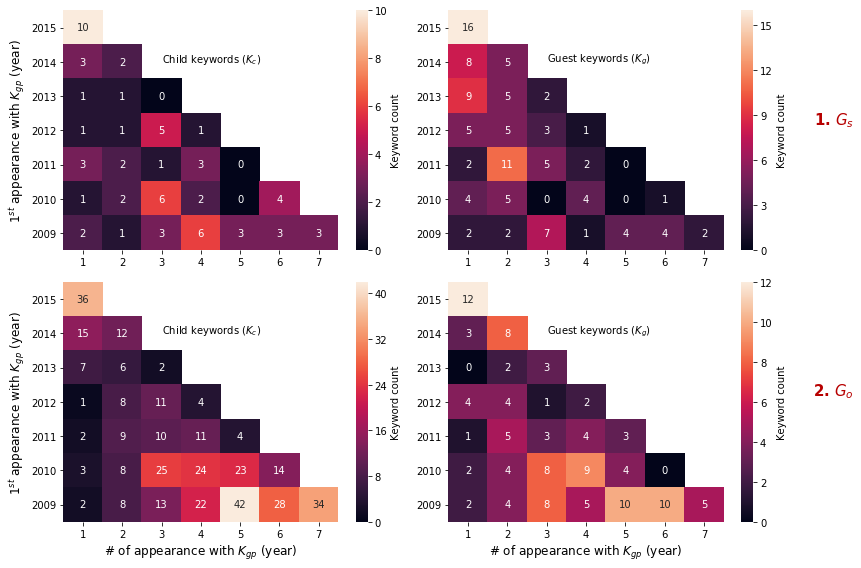

In [458]:
import seaborn as sns;
from textwrap import wrap
def plot_sns(ax,dfObj,args,i,j):
    plt.sca(ax)
    mask = np.zeros_like(dfObj, dtype=np.bool)
    mask[np.tril_indices_from(mask)] = True
    ax = sns.heatmap(dfObj,mask=mask==False,annot=True, fmt=".0f",cbar_kws={'label': 'Keyword count'})
    ax.text(2.5,1.5,args['name'][j])
    plt.yticks(rotation=0)
    if i==1:
        plt.xlabel('# of appearance with $K_{gp}$ (year)', fontsize=12)
    if j==0:
        plt.ylabel('$1^{st}$ appearance with $K_{gp}$ (year)', fontsize=12)
    if j==1:
        plt.title(""+str(i+1)+". "+args['title'][i], position=(1.4, .5),fontsize=15,fontweight='bold', color='#b70000')


args={'name':['Child keywords $(K_c)$','Guest keywords $(K_g)$'],
      'title':['$G_s$','$G_o$']}
ds=["$(G_{s})$","($G_{o})$"]
fig, axs = plt.subplots(2,2,figsize=(12,8))
# cbar_ax = fig.add_axes([1, .35, .03, .4])
flatui = ["#2ecc71", "#3498db",  "#e74c3c", "#34495e"]
dfs = [[df_c_a,df_g_a],[df_c_o,df_g_o]]
for ind in range(0,2):
    ax1=axs[ind]
    for i,ax in enumerate(ax1.flat):
        plot_sns(ax,dfs[ind][i],args,ind,i)
###save
plt.tight_layout()
figpath=root+'dataframes/'
fig_file_name = os.path.join(figpath,'emergence'+ ".pdf")
plt.savefig(fig_file_name)
plt.show()

#### Inter-year node pairs characteristics

In [290]:
#############--------Inter-year node pairs characteristics----------------------------###########################################
importlib.reload(fs)
importlib.reload(cl)
miss_ev = []
# for tout in range(1991,2008,8):
#     time =  [tout,tout+1,tout+8,1,1,20]
ts = time[1]
te = time[2]
g_train, g_test, g_parent, g_train_static, g_test_static = gr.graph_load(graphpath, time)
freq=10
#time=[2001,2007,2015,1,1,10]
train_data, train_data_static, parent_data, test_data_static, edge_list = cl.non_edge_feature_dataframe(g_train, 
                                                                                                         g_test,
                                                                                                         g_parent,
                                                                                                         g_train_static, 
                                                                                                         g_test_static,  
                                                                                                         time, 
                                                                                                         freq)
#     node_feature, train_data = fs.dynamic_graph_feature_set(df, key_list, train_data, g_parent, g_train, g_train_static, time)

###############################################################################################################################
#     filename= domain[select_domain]+"-train_data_"+str(time[1])+"-"+str(time[2])+".pkl"
#     filename_path = os.path.join(datapath,filename)
#     with open(filename_path,"rb") as f:
#         train_data = pickle.load(f)
#         print('train data length:',len(train_data))

#     filename= domain[select_domain]+"-node_feature_"+str(time[1])+"-"+str(time[2])+".pkl"
#     filename_path = os.path.join(datapath,filename)
#     with open(filename_path,"rb") as f:
#         node_feature = pickle.load(f)
#         print('node feature length:',len(node_feature))
################################################################################################################################
train_data = ut.load_data(datapath, domain[select_domain], "train_data", time)
node_feature = ut.load_data(datapath, domain[select_domain], "node_feature", time)
static_pos = set(train_data_static[(train_data_static['label']==1)]['row_name'])
dynamic_pos = set()
for t in range(ts,te,1):
    dynamic_pos.update(train_data[t][(train_data[t]['label']==1)]['row_name'])
transitory_edges = static_pos.difference(dynamic_pos)
transitory_nodes = set()
for row in transitory_edges:
    transitory_nodes.add(row[0])
    transitory_nodes.add(row[1]) 
nodes_te =set()
nodes_te1 = set()
nodes_teo = set()
for node in transitory_nodes:
    if (te-1) in set(g_train_static.nodes[node]['year']):
        nodes_te.add(node)
    if (te-2) in set(g_train_static.nodes[node]['year']):
        nodes_te1.add(node)
nodes_te1 = nodes_te1.difference(nodes_te)        
nodes_teo = transitory_nodes.difference(nodes_te,nodes_te1)
#print('n_te:',len(nodes_te),'n_te1:',len(nodes_te1),'n_teo:',len(nodes_teo),'n_tot:',len(transitory_nodes))
e_tete1= set()
e_teteo= set()
for row in transitory_edges:
    diff = len(set(row).difference(nodes_te))
    if diff==1:
        diff1 = len(set(row).difference(nodes_te1))
        if diff1 ==1:
            e_tete1.add(row)
        if diff1 ==2:
            e_teteo.add(row)
tot_te = len(e_tete1)+len(e_teteo)
rat = tot_te*100/len(transitory_edges)
#print('e_tete1:',len(e_tete1),'e_teteo:',len(e_teteo),'tot_e:',tot_te,'total:',len(transitory_edges),'rat:',rat) 
miss_ev.append([ts,te-1,len(nodes_te),len(nodes_te1),len(nodes_teo),len(transitory_nodes),
                len(e_tete1),len(e_teteo),tot_te,len(transitory_edges),rat])
cols = ['ts','te','n_te','n_te1','n_teo','n_trans','e_tete1','e_teteo','tot_te','tot_e_trans','rat']
gr_miss=pd.DataFrame(miss_ev, columns=cols)
gr_miss

../linkPrediction/graphs/apnea\train_graph_2008.gpickle loaded, nodes: 459 edges: 773
../linkPrediction/graphs/apnea\train_graph_2009.gpickle loaded, nodes: 470 edges: 688
../linkPrediction/graphs/apnea\train_graph_2010.gpickle loaded, nodes: 496 edges: 786
../linkPrediction/graphs/apnea\train_graph_2011.gpickle loaded, nodes: 536 edges: 977
../linkPrediction/graphs/apnea\train_graph_2012.gpickle loaded, nodes: 584 edges: 1054
../linkPrediction/graphs/apnea\train_graph_2013.gpickle loaded, nodes: 634 edges: 1280
../linkPrediction/graphs/apnea\train_graph_2014.gpickle loaded, nodes: 583 edges: 1144
../linkPrediction/graphs/apnea\test_graph_2015.gpickle loaded, nodes: 1093 edges: 2019
../linkPrediction/graphs/apnea\parent_graph_2007-2008.gpickle loaded, nodes: 388 edges: 689
../linkPrediction/graphs/apnea\train_graph_2008-2015.gpickle loaded, nodes: 1093 edges: 5142
../linkPrediction/graphs/apnea\test_graph_2015-2016.gpickle loaded, nodes: 1093 edges: 2019
pos
test_size: 1441
neg
test_si

,ts,te,n_te,n_te1,n_teo,n_trans,e_tete1,e_teteo,tot_te,tot_e_trans,rat
0,2008,2014,73,53,93,219,31,53,84,130,64.615385


### Print information

In [299]:
gr_type.transpose()
# print(gr_type)
# print(gr_type.to_latex(float_format=lambda x: '%.2f' % x))

,0,1,2,3,4,5,6
year,2008,2009,2010,2011,2012,2013,2014
k_gp,20,20,20,20,20,20,17
k_p,1765,1614,1752,1963,2109,2117,2252
k_c,430,360,409,334,368,370,793
k_g,141,98,117,91,82,75,155
e_gpgp1,3,2,0,0,1,0,2
e_gpp1,679,664,556,665,757,726,869
e_gpc1,185,157,153,125,131,148,323
e_gpg1,67,32,43,27,26,41,51
e_p,3729,3626,4072,4628,5723,5582,6903


In [ ]:
# gr_miss
#print(gr_miss.to_latex(float_format=lambda x: '%.2f' % x))

In [294]:
gr_ke
print(gr_ke.to_latex(float_format=lambda x: '%.2f' % x))

\begin{tabular}{lrrrrrrrrr}
\toprule
{} &  year &     k &   kn &    ko &     e &  e\_ooo &  e\_oon &  e\_no &  e\_nn \\
\midrule
0 &  2007 &   857 &  857 &     0 &  1486 &      0 &      0 &     0 &  1486 \\
1 &  2008 &   968 &  572 &   396 &  1690 &    144 &    530 &   777 &   239 \\
2 &  2009 &   978 &  438 &   540 &  1587 &    202 &    609 &   636 &   140 \\
3 &  2010 &  1000 &  332 &   668 &  1648 &    264 &    800 &   483 &   101 \\
4 &  2011 &  1172 &  345 &   827 &  2264 &    387 &   1166 &   599 &   112 \\
5 &  2012 &  1240 &  279 &   961 &  2399 &    271 &   1524 &   531 &    73 \\
6 &  2013 &  1328 &  272 &  1056 &  2715 &    424 &   1692 &   539 &    60 \\
7 &  2014 &  1367 &  291 &  1076 &  2728 &    500 &   1605 &   502 &   121 \\
8 &  2015 &  1262 &  157 &  1105 &  2347 &    512 &   1530 &   235 &    70 \\
\bottomrule
\end{tabular}



In [ ]:
#df.groupby('art_year').count()
# cols = ['year','total article']
# obesity_stat=pd.DataFrame(d2, columns=cols)
# print(obesity_stat.to_latex(float_format=lambda x: '%.2f' % x))

In [103]:
gr_ke

,year,k,kn,ko,e,e_ooo,e_oon,e_no,e_nn
0,2007,857,857,0,1486,0,0,0,1486
1,2008,968,572,396,1690,144,530,777,239
2,2009,978,438,540,1587,202,609,636,140
3,2010,1000,332,668,1648,264,800,483,101
4,2011,1172,345,827,2264,387,1166,599,112
5,2012,1240,279,961,2399,271,1524,531,73
6,2013,1328,272,1056,2715,424,1692,539,60
7,2014,1367,291,1076,2728,500,1605,502,121
8,2015,1262,157,1105,2347,512,1530,235,70


In [ ]:
gr_type

In [ ]:
print(gr_ke.to_latex(float_format=lambda x: '%.2f' % x))

1 [(5, 11), (20, 15), (5, 1)] [110, 150, 10]
2 [(20, 22), (5, 6), (1, 1)] [220, 60, 10]
3 [(5, 3), (1, 4), (1, 5)] [30, 40, 50]


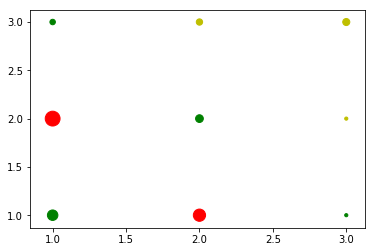

k1 {1: [(5, 11), (20, 15), (5, 1)], 2: [(20, 22), (5, 6), (1, 1)], 3: [(5, 3), (1, 4), (1, 5)]}
k2 {1: [(5, 11), (20, 15), (5, 1)], 2: [(20, 22), (5, 6), (1, 1)], 3: [(5, 3), (1, 4), (1, 5)]}


In [205]:
x1=[[1,1,1,1],[5,5,5,5],[9,9,9,9]]
x2=[[2,2,2,2],[6,6,6,6],[10,10,10,10]]
x3=[[3,3,3,3],[7,7,7,7],[11,11,11,11]]


x={1:[(5,11),(20,15),(5,1)],2:[(20,22),(5,6),(1,1)],3:[(5,3),(1,4),(1,5)]}
c={20:'r',5:'g',3:'b',1:'y'}
y=[1,2,3]
for key,val in x.items():
    colors =[c[v[0]] for v in val]
    size = [v[1]*10 for v in val]
    print(key,val,size)
    x= range(1,4,1)
    y=np.full(3,key)
    plt.scatter(x,y,c =colors,s=size) 
#     plt.scatter(x2[i],y) 
#     plt.scatter(x3[i],y) 
plt.show()



../linkPrediction/dataframes/apnea
../linkPrediction/dataframes/obesity


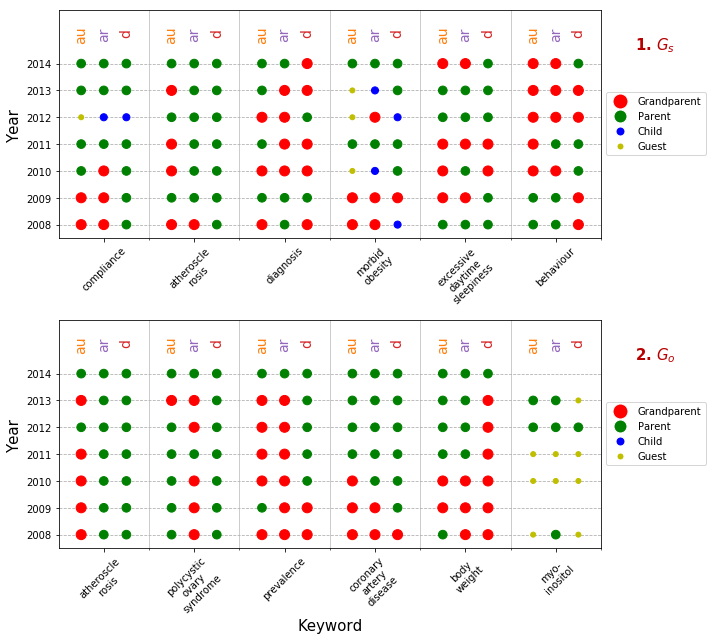

In [956]:
from matplotlib.lines import Line2D
from textwrap import wrap
fig, axs = plt.subplots(2,1,figsize=(10,9))
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Grandparent',
                          markerfacecolor='r', markersize=15),
                   Line2D([0], [0], marker='o', color='w', label='Parent',
                          markerfacecolor='g', markersize=13),
                  Line2D([0], [0], marker='o', color='w', label='Child',
                          markerfacecolor='b', markersize=9),
                  Line2D([0], [0], marker='o', color='w', label='Guest',
                          markerfacecolor='y', markersize=7)]
c={20:'r',5:'g',3:'b',1:'y'}
title = ['$G_s$','$G_o$']
for ind in range(0,2,1):
    ax=axs[ind]
    ax.set_axisbelow(True)
    ax.grid(axis='y', linestyle='--')
    # major_ticks = np.arange(0, 8, .5)
    minor_ticks = np.arange(4, 26, 4)

    # ax.set_xticks(major_ticks)
    ax.set_xticks(minor_ticks, minor=True)
    # ax.set_yticks(major_ticks)
    # ax.set_yticks(minor_ticks, minor=True)
    ax.grid(which='minor',linestyle='-', alpha=.8)
    plt.sca(ax)
    plt.ylim(-0.5, 8)
    plt.xlim(0, 24)
    
    count = 1
    xtick=[]
    ytick=[2008,2009,2010,2011,2012,2013,2014]
    X = ut.load_data('../linkPrediction/dataframes/'+domain[ind], domain[ind], "relative_heredity", time)
    for K,item in X.items():
        for key,val in item.items():
    #         print(key,val,count)
            y=np.full(3,key)
            x= range(count,count+3,1)
    #         print(y,x)
            colors =[c[v[0]] for v in val]
            size = [v[1]*5 for v in val]
            for i,cc in enumerate(size):
                if cc==25:
                    size[i]=75
                if cc==15:
                    size[i]=50
                if cc==5:
                    size[i]=25
            plt.scatter(x,y,c =colors,s=size)  
            if (key==0):
                ax.text(count, 7,'au', color='C1',horizontalalignment='center',fontsize=14,rotation=90)
                ax.text(count+1, 6.95,'ar', color='C4',horizontalalignment='center',fontsize=14,rotation=90)
                ax.text(count+2, 6.9,'d', color='C3',horizontalalignment='center',fontsize=14,rotation=90)            
        count=count+4
        xtick.append(K)
    xtick = [ '\n'.join(wrap(l, 10)) for l in xtick ]
    x_pos = np.arange(len(xtick))
    plt.xticks(x_pos*4+2, xtick, rotation=45)    
    ax.legend(handles=legend_elements, loc='center left',bbox_to_anchor=(1, 0.5))
    y_pos = np.arange(len(ytick))
    plt.yticks(y_pos, ytick, rotation=0)
    plt.ylabel('Year', fontsize=15)
    plt.title(""+str(ind+1)+". "+title[ind], position=(1.1, .8),fontsize=15,fontweight='bold', color='#b70000')
plt.xlabel('Keyword', fontsize=15)
plt.tight_layout()
###save
figpath=root+'dataframes/'
fig_file_name = os.path.join(figpath,'heredity'+ ".pdf")
plt.savefig(fig_file_name)
plt.show()

In [253]:
9%4 f =['auc','art','deg']

1

In [812]:
# t=2011
# node_feature[t][(node_feature[t]['node_type_aut']==3) | 
#                        (node_feature[t]['node_type_art']==3) |
#                        (node_feature[t]['node_type_deg']==3)]

In [813]:
# t=2008
# ns = {}
# for t in range(2008,2015,1):
#     rl = node_feature[t][(node_feature[t]['node_type_aut']==3) | 
#                        (node_feature[t]['node_type_art']==3) |
#                        (node_feature[t]['node_type_deg']==3)]
#     ns[t]=set()
#     for index,row in rl.iterrows():
#         if not(row['node_type_aut']==20 and row['node_type_art']==20 and row['node_type_deg']==20):
#             print(row['node_index'],row['node_type_aut'],row['node_type_art'],row['node_type_deg'])
#             ns[t].add(row['node_index'])
#     print("-----------------------------------")

In [645]:
ns[2013].intersection(ns[2014])

set()

In [ ]:
{853.0, 8528.0, 8786,2429,7943}

In [105]:
#apnea
nodelist = [3166, 1142, 4004,8896, 4522,1513]
# nodelist = [853, 8528, 8786,2429,1335,7943]

5 9
5 4
5 8
5 9
3 5
5 6
5 16
[5, 5, 5, 5, 3, 5, 5]
5 10
5 7
5 9
5 11
5 14
5 9
5 12
[5, 5, 5, 5, 5, 5, 5]
20 9
5 18
20 14
20 13
5 19
20 25
20 15
[20, 5, 20, 20, 5, 20, 20]
3 20
20 10
5 11
5 9
3 6
5 12
5 10
[3, 20, 5, 5, 3, 5, 5]
5 12
5 12
20 16
20 11
5 14
5 17
5 13
[5, 5, 20, 20, 5, 5, 5]
20 13
20 10
5 13
5 24
20 23
20 17
5 20
[20, 20, 5, 5, 20, 20, 5]


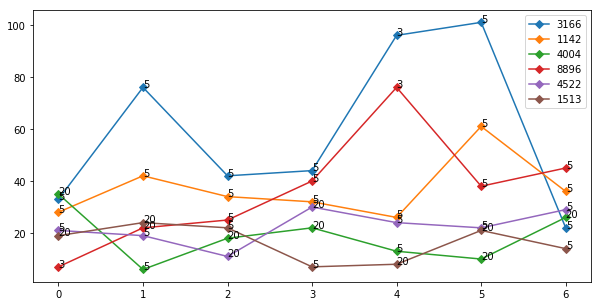

In [106]:
from matplotlib.lines import Line2D
# nodelist = [3166, 1142, 4004,8896, 4522,1513]
X={}
fig, axs = plt.subplots(figsize=(10,5))
for node in nodelist:
    n=gr.node_label_find(key_list,node)
    X[n]={}
    X[n][1]=[]
    X[n][2]=[]
    for t in range(2008,2015,1):
        if node in set(node_feature[t]['node_index']):
            l=node_feature[t].loc[node_feature[t]['node_index']==node,['node_type_deg','degree']]
            d=l.iloc[0][0]
            degree=l.iloc[0][1]
        tt=[n for (n,d) in sorted(g_train[t].degree, key=lambda x: x[1], reverse=True)]
        print(d,degree)
        X[n][1].append(d)
        X[n][2].append(tt.index(node))
    plt.plot(X[n][2],'D-',label=node) 
    plt.legend(loc='best')
    for i,dd in enumerate(X[n][1]):
        axs.annotate(dd,(i,X[n][2][i]))
    print(X[n][1])
plt.show()

In [84]:
# x1=X
x2=X

In [66]:
import math
X={'k1':{1:[(5,11),(20,15),(5,1)],2:[(20,22),(5,6),(1,1)],3:[(5,3),(1,4),(1,5)]},
  'k2':{1:[(20,11),(1,15),(3,1)],2:[(20,22),(3,6),(1,1)],3:[(5,3),(1,4),(20,5)]},
  'k3':{1:[(5,11),(5,15),(20,1)],2:[(1,22),(5,6),(5,1)],3:[(1,3),(5,4),(1,5)]}}
X={}
Y={}
for node in nodelist:
    n=gr.node_label_find(key_list,node)
    X[n]={}
    Y[n]={}
    for t in range(2008,2015,1):
#         node_feature[t]['term_aut'] = ut.min_max_norm(node_feature[t]['term_aut'])
#         node_feature[t]['term_art'] = ut.min_max_norm(node_feature[t]['term_art'])
#         node_feature[t]['degree'] = ut.min_max_norm(node_feature[t]['degree'])
        if node in set(node_feature[t]['node_index']):
            l=node_feature[t].loc[node_feature[t]['node_index']==node,['node_type_aut','node_type_art',
                                                                       'node_type_deg','term_aut','term_art','degree']]
            #print(node,t,l.iloc[0][0],l.iloc[0][1],l.iloc[0][2],l.iloc[0][3])
            au=l.iloc[0][0]
            ar=l.iloc[0][1]
            d=l.iloc[0][2]
            tau=l.iloc[0][0]
            tar=l.iloc[0][1]
            td=l.iloc[0][2]
            
            X[n][t-2008]=[(au,tau),(ar,tar),(d,td)]
            print(len(g_train[t][node])*100/len(g_train[t].edges()),d)
    print("---------------",node)

0.6224469947481035 5.0
0.7444879259329961 5.0
0.6916090325806182 5.0
0.6446640039240418 5.0
0.6436440153484342 5.0
0.422686265850735 5.0
0.47702598969185217 5.0
--------------- 853
0.6418984633339817 5.0
0.6013171709458814 5.0
0.591617365219565 5.0
0.7427650479994394 5.0
0.6622106696373313 5.0
0.5299350198725632 5.0
0.35091567057791423 5.0
--------------- 8528
0.8655903520715814 20.0
0.8494798129235468 20.0
0.7249395883676361 5.0
0.7077289608296545 5.0
0.6126995915336056 5.0
0.5867137720017664 5.0
0.5702379646891107 5.0
--------------- 8786
0.8169616806068858 20.0
0.6681301899398683 5.0
0.6082826431130739 5.0
0.6867073085277836 5.0
0.6065107067706399 5.0
0.5488612705822976 5.0
0.18094089264173704 5.0
--------------- 2429
1.1184594436879984 20.0
1.0785530209029301 20.0
0.9415882009832514 20.0
0.9810104407539766 20.0
0.8478772125263028 20.0
0.6434925241309697 20.0
0.668932997039149 5.0
--------------- 1335
0.019451468585878234 1.0
0.008332638946754437 1.0
0.007007217433956976 1.0
0.03713

In [871]:
X
#l=node_feature[t].loc[node_feature[t]['node_index']==3166,['node_type_aut','node_type_art','node_type_deg']]

{'atherosclerosis': {0: [(20.0, 20.0), (5.0, 5.0), (5.0, 5.0)],
  1: [(20.0, 20.0), (5.0, 5.0), (5.0, 5.0)],
  2: [(20.0, 20.0), (5.0, 5.0), (5.0, 5.0)],
  3: [(20.0, 20.0), (5.0, 5.0), (5.0, 5.0)],
  4: [(5.0, 5.0), (5.0, 5.0), (5.0, 5.0)],
  5: [(20.0, 20.0), (5.0, 5.0), (5.0, 5.0)],
  6: [(5.0, 5.0), (5.0, 5.0), (5.0, 5.0)]},
 'polycystic ovary syndrome': {0: [(5.0, 5.0), (20.0, 20.0), (5.0, 5.0)],
  1: [(5.0, 5.0), (20.0, 20.0), (5.0, 5.0)],
  2: [(5.0, 5.0), (20.0, 20.0), (5.0, 5.0)],
  3: [(5.0, 5.0), (5.0, 5.0), (5.0, 5.0)],
  4: [(5.0, 5.0), (20.0, 20.0), (5.0, 5.0)],
  5: [(20.0, 20.0), (20.0, 20.0), (5.0, 5.0)],
  6: [(5.0, 5.0), (5.0, 5.0), (5.0, 5.0)]},
 'prevalence': {0: [(20.0, 20.0), (20.0, 20.0), (20.0, 20.0)],
  1: [(5.0, 5.0), (20.0, 20.0), (20.0, 20.0)],
  2: [(20.0, 20.0), (20.0, 20.0), (5.0, 5.0)],
  3: [(20.0, 20.0), (20.0, 20.0), (5.0, 5.0)],
  4: [(20.0, 20.0), (20.0, 20.0), (5.0, 5.0)],
  5: [(20.0, 20.0), (20.0, 20.0), (5.0, 5.0)],
  6: [(5.0, 5.0), (5.0, 5.0)

In [404]:
l.iloc[0][0:3]

node_type_aut    5
node_type_art    5
node_type_deg    5
Name: 18, dtype: int64

In [420]:
k=[(1,2),(2,3)]

In [571]:
from textwrap import wrap
labels=['Really really really really really really long label 1',
        'Really really really really really really long label 2',
        'Really really really really really really long label 3']
xtick = [ '\n'.join(wrap(l, 10)) for l in xtick]

In [873]:
ut.save_data(X, datapath, domain[select_domain], "relative_heredity", time)

../linkPrediction/dataframes/obesity\obesity-relative_heredity_2008-2015.pkl


In [875]:
X = ut.load_data('../linkPrediction/dataframes/obesity', domain[select_domain], "relative_heredity", time)

../linkPrediction/dataframes/obesity


In [125]:
tt=[n for (n,d) in sorted(g_train[2009].degree, key=lambda x: x[1], reverse=True)]


In [164]:
last_year=[]
old=set()
for t in range(2014,2007,-1):
    present = set(train_data[t][(train_data[t]['label']==1)]['row_name'])
    new=present.difference(old)
    print(len(new),len(present))
    old.update(present)
    last_year.append(len(new))
fst_year=[]
old=set()
for t in range(2008,2015,1):
    present = set(train_data[t][(train_data[t]['label']==1)]['row_name'])
    new=present.difference(old)
    print(len(new),len(present))
    old.update(present)
    fst_year.append(len(new))

10909 10909
1254 8187
355 7913
105 6709
34 6373
13 5798
403 6142
6142 6142
1711 5798
836 6373
503 6709
811 7913
463 8187
2607 10909


In [155]:
last_year[::-1]

[27, 40, 77, 95, 146, 266, 660]

In [156]:
fst_year

[484, 210, 149, 133, 129, 121, 85]

In [185]:
un

[27, 27, 46, 57, 63, 85, 85]

In [165]:
last_year[::-1]

[403, 13, 34, 105, 355, 1254, 10909]

In [195]:
result_rec={'apnea':{'first':[484, 210, 149, 133, 129, 121, 85],
                  'last':[27, 40, 77, 95, 146, 266, 660],
                  'unique':[27, 27, 46, 57, 63, 85, 85]},
        'obesity':{'first':[6142, 1711, 836, 503, 811, 463, 2607],
                  'last':[403, 13, 34, 105, 355, 1254, 10909],
                  'unique':[403, 11, 11, 11, 72, 87, 2607]}}

In [166]:
fst_year

[6142, 1711, 836, 503, 811, 463, 2607]

In [180]:
un

[403, 11, 11, 11, 72, 87, 2607]

In [184]:
un=[]
for t in range(2008,2015,1):
    present = set(train_data[t][(train_data[t]['label']==1)]['row_name'])
    other = set()
    for tt in range(2008,2015,1):
        if tt!=t:
            temp = set(train_data[tt][(train_data[tt]['label']==1)]['row_name'])
            other.update(temp)
    unique=present.difference(other)
    print(len(unique))
    un.append(len(unique))

27
27
46
57
63
85
85


../linkPrediction/dataframes/apnea
../linkPrediction/dataframes/obesity


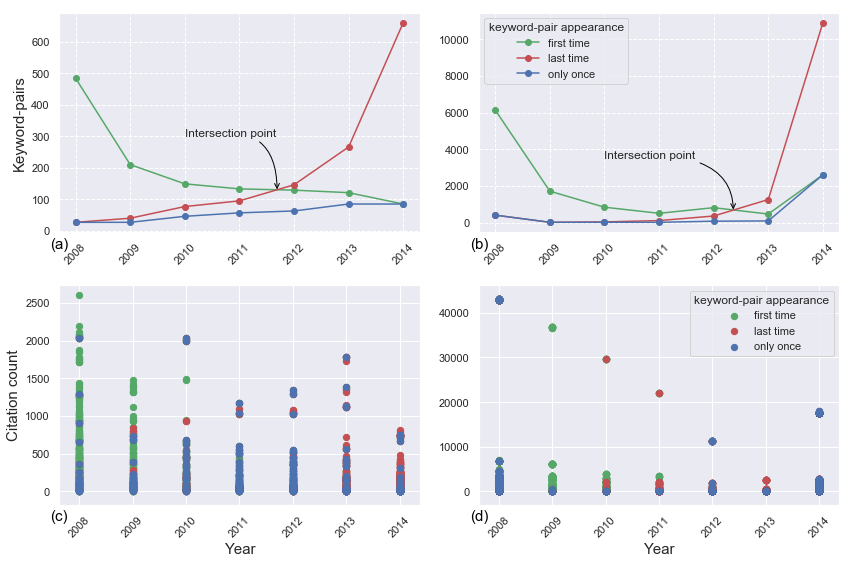

In [272]:
import seaborn as sns; sns.set(color_codes=True)
result_rec={'apnea':{'first time':[484, 210, 149, 133, 129, 121, 85],
                  'last time':[27, 40, 77, 95, 146, 266, 660],
                  'only once':[27, 27, 46, 57, 63, 85, 85]},
        'obesity':{'first time':[6142, 1711, 836, 503, 811, 463, 2607],
                  'last time':[403, 13, 34, 105, 355, 1254, 10909],
                  'only once':[403, 11, 11, 11, 72, 87, 2607]}}
serial=[['(a)','(b)'],['(c)','(d)']]
fig, axs = plt.subplots(2,2,figsize=(12,8))
title = ['$G_s$','$G_o$']
col=['g','r','b']
for ind in range(0,2,1):
    ax=axs[0][ind]
    ax.set_axisbelow(True)
    ax.grid(axis='both', linestyle='--')
    # major_ticks = np.arange(0, 8, .5)
    minor_ticks = np.arange(4, 26, 4)

    # ax.set_xticks(major_ticks)
#     ax.set_xticks(minor_ticks, minor=True)
    # ax.set_yticks(major_ticks)
    # ax.set_yticks(minor_ticks, minor=True)
#     ax.grid(which='minor',linestyle='-', alpha=.8)
    plt.sca(ax)
#     plt.ylim(-0.5, 8)
#     plt.xlim(0, 24)
    count = 0
    for name,res in result_rec[domain[ind]].items():
        ax.plot(res,'o-',c=col[count],label=name)
        count=count+1
    xtick=[]
    xtick=[2008,2009,2010,2011,2012,2013,2014]
    x_pos = np.arange(len(xtick))
    plt.xticks(x_pos, xtick, rotation=45)
    if ind==1:
        plt.legend(title="keyword-pair appearance",loc='best',fancybox=True)
    plt.title(""+str(serial[0][ind]), position=(.0, -.1),fontsize=15, color='black')
    if ind==0:
        plt.ylabel('Keyword-pairs', fontsize=15)

axs[0][1].annotate('Intersection point', xy=(4.36, 600), xytext=(2, 3500),
    arrowprops=dict(arrowstyle="->",
                    connectionstyle="angle3,angleA=0,angleB=-90",color='black'));
    
axs[0][0].annotate('Intersection point', xy=(3.69, 125), xytext=(2, 300),
        arrowprops=dict(arrowstyle="->",
                        connectionstyle="angle3,angleA=0,angleB=-90",color='black'));


markers=['o','o','o']
size=[40,40,40]

for ind in range(0,2):
    ax=axs[1][ind]
    plt.sca(ax)
    cite_fast,year_fast,cite_last,year_last,cite_un,year_un = citt(ind)
    ax.scatter(year_fast,cite_fast,c=col[0],label='first time',marker=markers[0],s=size[0])
    ax.scatter(year_last,cite_last,c=col[1],label='last time',marker=markers[1],s=size[1])
    ax.scatter(year_un,cite_un,c=col[2],label='only once',marker=markers[2],s=size[2])
    xtick=[]
    xtick=[2008,2009,2010,2011,2012,2013,2014]
    plt.xticks(xtick, rotation=45)
    if ind==1:
        plt.legend(title="keyword-pair appearance",loc='best',fancybox=True)

    plt.title(""+str(serial[1][ind]), position=(0, -0.1),fontsize=15, color='black')
    if ind==0:
        plt.ylabel('Citation count', fontsize=15)
    plt.xlabel('Year', fontsize=15)
###save
plt.tight_layout()
figpath=root+'dataframes/'
fig_file_name = os.path.join(figpath,'recency'+ ".pdf")
plt.savefig(fig_file_name)
plt.show()

../linkPrediction/dataframes/apnea
../linkPrediction/dataframes/obesity


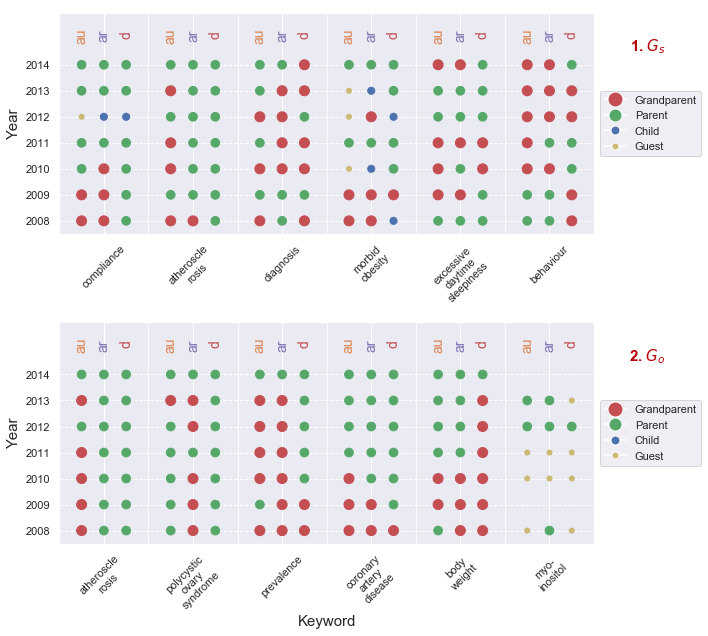

In [218]:
from matplotlib.lines import Line2D
from textwrap import wrap
fig, axs = plt.subplots(2,1,figsize=(10,9))
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Grandparent',
                          markerfacecolor='r', markersize=15),
                   Line2D([0], [0], marker='o', color='w', label='Parent',
                          markerfacecolor='g', markersize=13),
                  Line2D([0], [0], marker='o', color='w', label='Child',
                          markerfacecolor='b', markersize=9),
                  Line2D([0], [0], marker='o', color='w', label='Guest',
                          markerfacecolor='y', markersize=7)]
c={20:'r',5:'g',3:'b',1:'y'}
title = ['$G_s$','$G_o$']
for ind in range(0,2,1):
    ax=axs[ind]
    ax.set_axisbelow(True)
    ax.grid(axis='y', linestyle='--')
    # major_ticks = np.arange(0, 8, .5)
    minor_ticks = np.arange(4, 26, 4)

    # ax.set_xticks(major_ticks)
    ax.set_xticks(minor_ticks, minor=True)
    # ax.set_yticks(major_ticks)
    # ax.set_yticks(minor_ticks, minor=True)
    ax.grid(which='minor',linestyle='-', alpha=.8)
    plt.sca(ax)
    plt.ylim(-0.5, 8)
    plt.xlim(0, 24)
    
    count = 1
    xtick=[]
    ytick=[2008,2009,2010,2011,2012,2013,2014]
    X = ut.load_data('../linkPrediction/dataframes/'+domain[ind], domain[ind], "relative_heredity", time)
    for K,item in X.items():
        for key,val in item.items():
    #         print(key,val,count)
            y=np.full(3,key)
            x= range(count,count+3,1)
    #         print(y,x)
            colors =[c[v[0]] for v in val]
            size = [v[1]*5 for v in val]
            for i,cc in enumerate(size):
                if cc==25:
                    size[i]=75
                if cc==15:
                    size[i]=50
                if cc==5:
                    size[i]=25
            plt.scatter(x,y,c =colors,s=size)  
            if (key==0):
                ax.text(count, 7,'au', color='C1',horizontalalignment='center',fontsize=14,rotation=90)
                ax.text(count+1, 6.95,'ar', color='C4',horizontalalignment='center',fontsize=14,rotation=90)
                ax.text(count+2, 6.9,'d', color='C3',horizontalalignment='center',fontsize=14,rotation=90)            
        count=count+4
        xtick.append(K)
    plt.title(""+str(ind+1)+". "+title[ind], position=(1.1, .8),fontsize=15,fontweight='bold', color='#b70000')
    xtick = [ '\n'.join(wrap(l, 10)) for l in xtick ]
    x_pos = np.arange(len(xtick))
    plt.xticks(x_pos*4+2, xtick, rotation=45)    
    ax.legend(handles=legend_elements, loc='center left',bbox_to_anchor=(1, 0.5))
    y_pos = np.arange(len(ytick))
    plt.yticks(y_pos, ytick, rotation=0)
    plt.ylabel('Year', fontsize=15)
    plt.title(""+str(ind+1)+". "+title[ind], position=(1.1, .8),fontsize=15,fontweight='bold', color='#b70000')
plt.xlabel('Keyword', fontsize=15)
plt.tight_layout()
###save
figpath=root+'dataframes/'
fig_file_name = os.path.join(figpath,'heredity'+ ".pdf")
plt.savefig(fig_file_name)
plt.show()

In [13]:
def return_df(ind):
    d_au={}
    d_ar={}
    d_d={}
    h_val={20:4,5:3,3:2,1:1}
    X = ut.load_data('../linkPrediction/dataframes/'+domain[ind], domain[ind], "relative_heredity", time)
    for r,c in X.items():
        d_au[r]={}
        d_ar[r]={}
        d_d[r]={}
        for val1,val2 in c.items():
            d_au[r][2008+val1]=h_val[val2[0][0]]
            d_ar[r][2008+val1]=h_val[val2[1][0]]
            d_d[r][2008+val1]=h_val[val2[2][0]]
    #         print(r,val1,val2[1][0])
    dfs={}
    dfs[0] = pd.DataFrame(d_au)
    dfs[1] = pd.DataFrame(d_ar)
    dfs[2] = pd.DataFrame(d_d)
    return dfs

../linkPrediction/dataframes/obesity
../linkPrediction/dataframes/obesity


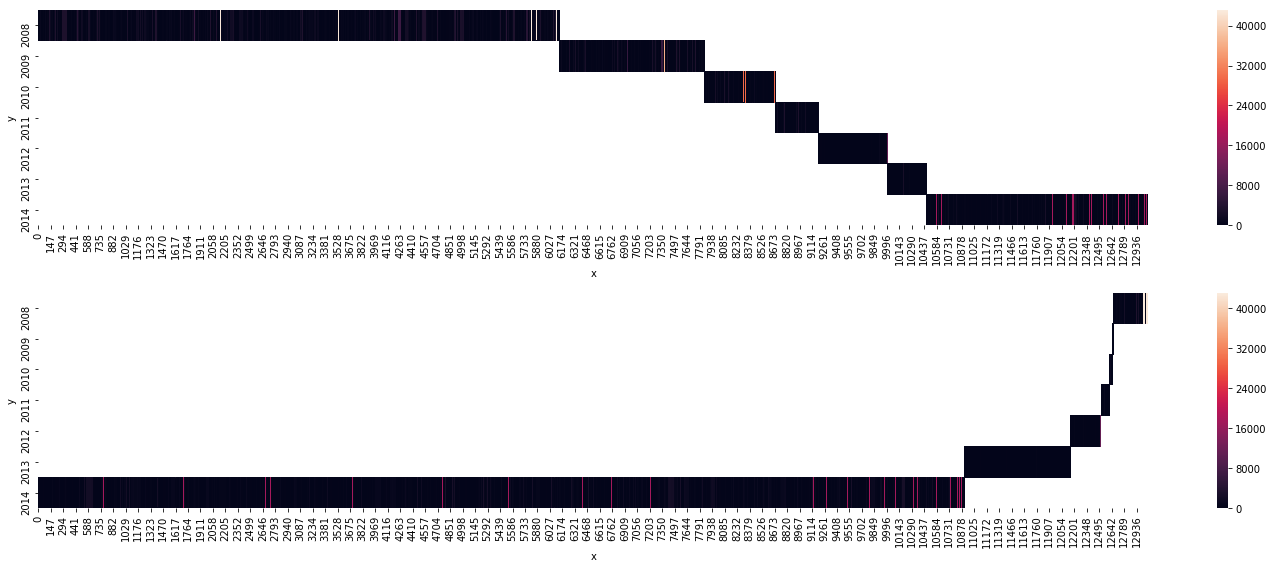

In [62]:
import seaborn as sns;
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(2,1,figsize=(20,8))

ax=axs[0]
plt.sca(ax)
cite_fast,year_fast,cite_last,year_last,cite_un,year_un = citt(1)
data = pd.DataFrame(data={'x':range(0,len(year_fast)), 'y':year_fast, 'z':cite_fast})
data = data.pivot(index='y', columns='x', values='z')
ax1 = sns.heatmap(data)

ax=axs[1]
plt.sca(ax)
cite_fast,year_fast,cite_last,year_last,cite_un,year_un = citt(1)
data = pd.DataFrame(data={'x':range(0,len(year_last)), 'y':year_last, 'z':cite_last})
data = data.pivot(index='y', columns='x', values='z')
ax = sns.heatmap(data)

plt.tight_layout()
plt.show()

../linkPrediction/dataframes/apnea
../linkPrediction/dataframes/obesity


C:\Users\faisal\Anaconda3\lib\site-packages\matplotlib\figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


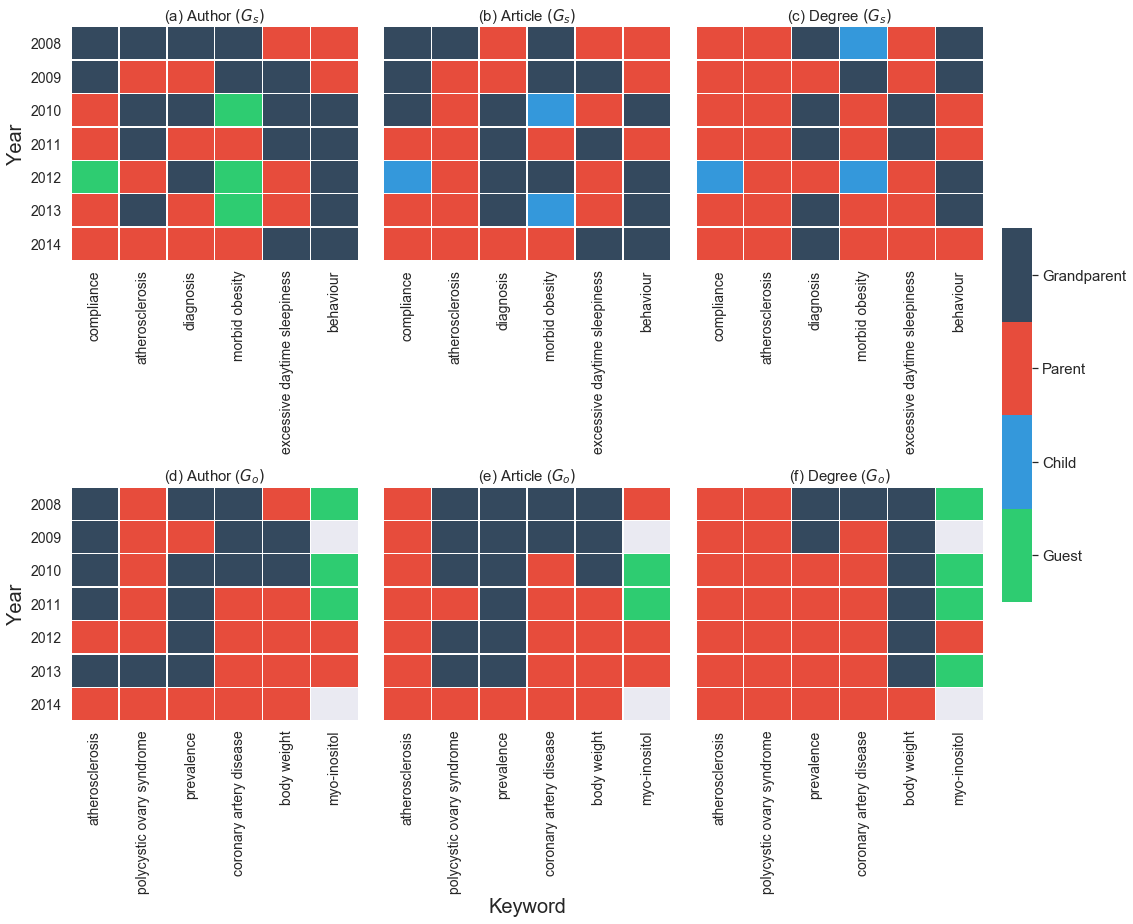

In [272]:
import seaborn as sns;
from textwrap import wrap
titles=['Author','Article','Degree']
no=[['a','b','c'],['d','e','f']]
ds=["$(G_{s})$","($G_{o})$"]
fig, axs = plt.subplots(2,3,figsize=(14,13))
cbar_ax = fig.add_axes([1, .35, .03, .4])
flatui = ["#2ecc71", "#3498db",  "#e74c3c", "#34495e"]
for ind in range(0,2):
    dfs=return_df(ind)
    ax1=axs[ind]
    for i,ax in enumerate(ax1.flat):
        plt.sca(ax)
        ax = sns.heatmap(dfs[i],cbar=i==0,
                         linewidths=.5,
                        vmin=0.5, vmax=4.5,
                         yticklabels=i==0,cmap=sns.color_palette(flatui),
                        cbar_ax=None if i else cbar_ax)
        if i==0:
            cbar = ax.collections[0].colorbar
            cbar.ax.tick_params(labelsize=15)
            cbar.set_ticks([4, 3, 2, 1])
            cbar.set_ticklabels(['Grandparent', 'Parent', 'Child', 'Guest'])
        x_pos = np.arange(len(dfs[i].columns.values))
        x_ticks =  [ '\n'.join(wrap(l, 10)) for l in dfs[i].columns.values ]
        x_ticks =  dfs[i].columns.values
        plt.xticks(x_pos+0.5,x_ticks, fontsize=14,rotation=90)
        plt.yticks(fontsize=14,rotation=0)
        if i==0:
            plt.ylabel('Year', fontsize=20)
        if i==1 and ind==1:
            plt.xlabel('Keyword', fontsize=20)
        plt.title("("+no[ind][i]+") "+titles[i]+" "+ds[ind],fontsize=15)
plt.tight_layout()
###save
figpath=root+'dataframes/'
fig_file_name = os.path.join(figpath,'heredity_variation'+ ".png")
plt.savefig(fig_file_name,bbox_inches='tight')
plt.show()

In [236]:
X ={'apnea':{'compliance': {1: [5, 5, 5, 5, 3, 5, 5], 2: [33, 76, 42, 44, 96, 101, 22]},
 'diagnosis': {1: [20, 5, 20, 20, 5, 20, 20], 2: [35, 6, 18, 22, 13, 10, 26]},
 'morbid obesity': {1: [3, 20, 5, 5, 3, 5, 5], 2: [7, 22, 25, 40, 76, 38, 45]},
 'behaviour': {1: [20, 20, 5, 5, 20, 20, 5], 2: [19, 24, 22, 7, 8, 21, 14]}}
,
   'obesity':{'atherosclerosis': {1: [5, 5, 5, 5, 5, 5, 5],
  2: [34, 28, 30, 35, 26, 61, 42]},
 'polycystic ovary syndrome': {1: [5, 5, 5, 5, 5, 5, 5],
  2: [30, 40, 40, 27, 24, 43, 68]},
 'prevalence': {1: [20, 20, 5, 5, 5, 5, 5], 2: [17, 22, 26, 30, 29, 31, 35]},
 'body weight': {1: [20, 20, 20, 20, 20, 20, 5],
  2: [13, 15, 19, 17, 19, 25, 24]}}}


In [109]:
ut.save_data(X,'../linkPrediction/dataframes','apnea-obesity', "degree_rank", time)

../linkPrediction/dataframes\apnea-obesity-degree_rank_2008-2015.pkl


In [110]:
X=ut.load_data('../linkPrediction/dataframes','apnea-obesity', "degree_rank", time)

../linkPrediction/dataframes


In [267]:
from math import ceil
def data_count(data):
    train_data={}
    year=2015
    train_data=data
    e_gpgp1 = train_data[year].loc[(train_data[year]['label']==1) & (train_data[year]['type']==400),['type']].count()
    e_gpgp0 = train_data[year].loc[(train_data[year]['label']==0) & (train_data[year]['type']==400),['type']].count()
    e_gpp1 = train_data[year].loc[(train_data[year]['label']==1) & (train_data[year]['type']==100),['type']].count()
    e_gpp0 = train_data[year].loc[(train_data[year]['label']==0) & (train_data[year]['type']==100),['type']].count()
    e_gpc1 = train_data[year].loc[(train_data[year]['label']==1) & (train_data[year]['type']==60),['type']].count()
    e_gpc0 = train_data[year].loc[(train_data[year]['label']==0) & (train_data[year]['type']==60),['type']].count()
    e_gpg1 = train_data[year].loc[(train_data[year]['label']==1) & (train_data[year]['type']==20),['type']].count()
    e_gpg0 = train_data[year].loc[(train_data[year]['label']==0) & (train_data[year]['type']==20),['type']].count()
    e_pc1  = train_data[year].loc[(train_data[year]['label']==1) & (train_data[year]['type']==15),['type']].count()
    e_pg1  = train_data[year].loc[(train_data[year]['label']==1) & (train_data[year]['type']==5),['type']].count()
    e_cg1  = train_data[year].loc[(train_data[year]['label']==1) & (train_data[year]['type']==3),['type']].count()
    e_p  = train_data[year].loc[(train_data[year]['label']==1) & (train_data[year]['type']==25),['type']].count()
    e_c  = train_data[year].loc[(train_data[year]['label']==1) & (train_data[year]['type']==9),['type']].count()
    e_g  = train_data[year].loc[(train_data[year]['label']==1) & (train_data[year]['type']==1),['type']].count()
    total  = train_data[year].loc[train_data[year]['label']==1,['type']].count()
    #tot_gp = e_gpgp1[0] + e_gpp1[0] + e_gpc1[0]+ e_gpg1[0]+e_pc1[0]+e_pg1[0]+e_cg1[0]
    ratgpgp = e_gpgp1[0]*100/total[0]
    ratgpp = e_gpp1[0]*100/total[0]
    ratgpc = e_gpc1[0]*100/total[0]
    ratgpg = e_gpg1[0]*100/total[0]
    ratpc = e_pc1[0]*100/total[0]
    ratpg = e_pg1[0]*100/total[0]
    ratcg = e_cg1[0]*100/total[0]
    ratp = e_p[0]*100/total[0]
    ratc = e_c[0]*100/total[0]
    ratg = e_g[0]*100/total[0]
    rat=[ceil(ratgpgp),ceil(ratgpp),ceil(ratp),ceil(ratpc), ceil(ratc), ceil(ratcg), ceil(ratg)]
    rat1=[e_gpgp1[0] , e_gpp1[0] , e_p[0], e_pc1[0] ,e_c[0], e_cg1[0], e_g[0]]
    print(rat1)
    return rat

../linkPrediction/dataframes/apnea
../linkPrediction/dataframes/obesity
[48, 609, 479, 451, 167, 103, 162]
[3, 31, 24, 23, 9, 6, 9]
[149, 6427, 12030, 2599, 357, 45, 43]
[1, 30, 56, 13, 2, 1, 1]


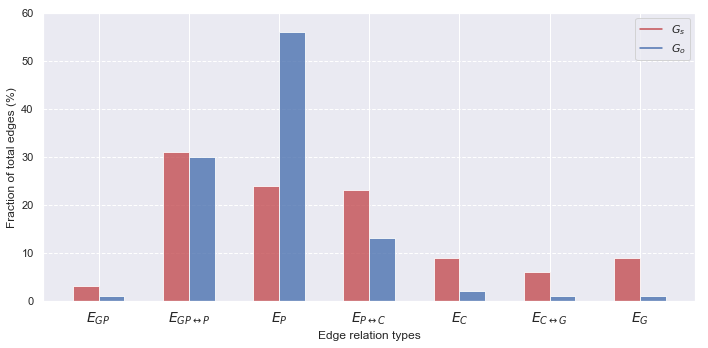

In [289]:
from matplotlib.lines import Line2D
from textwrap import wrap

time=[2014,2015,2016,1,1,20]
test_data=[]
test_data.append(ut.load_data('../linkPrediction/dataframes/apnea','apnea', "test_data", time))
test_data.append(ut.load_data('../linkPrediction/dataframes/obesity','obesity', "test_data", time))

title = ['$G_s$','$G_o$']
col=['r','b','b']
bar_width = 1
types={3:'ch',5:'p',20:'gp'}
c={20:'r',5:'g',3:'b',1:'y'}
sp=3.5
xtick=[]
x_ind=np.array([0,sp*1,sp*2,sp*3,sp*4,sp*5,sp*6])

legend_elements = [Line2D([0], [0], color='r', label='$G_s$'),
                   Line2D([0], [0],  color='b', label='$G_o$')]
fig, ax = plt.subplots(1,1,figsize=(10,5))
plt.ylim(0, 60)
# plt.xlim(-, 24)

ax.set_axisbelow(True)
ax.grid(axis='y', linestyle='--')
# major_ticks = np.arange(0, 8, .5)
major_ticks = np.arange(2.6,21,3.5)

ax.set_xticks(major_ticks)
# ax.set_xticks(minor_ticks, major=True)
# ax.set_yticks(major_ticks)
# ax.set_yticks(minor_ticks, minor=True)
ax.grid(which='minor',linestyle='-', alpha=.8)
for i,data in enumerate(test_data):
    rat = data_count(data)
    print(rat)
    ax.bar(x_ind+i,rat,bar_width,align='center',alpha=0.8,color=col[i])
xtick=['$E_{GP}$','$E_{GP\leftrightarrow P}$','$E_{P}$','$E_{P\leftrightarrow C}$','$E_{C}$','$E_{C\leftrightarrow G}$',
       '$E_{G}$']
x_pos = np.arange(.5,24,3.5)
plt.xticks(x_pos, xtick, fontsize=14,rotation=0)
ax.legend(handles=legend_elements, loc='best')
plt.xlabel('Edge relation types', fontsize=12)
plt.ylabel('Fraction of total edges (%)', fontsize=12)
plt.tight_layout()
###save
figpath=root+'dataframes/'
fig_file_name = os.path.join(figpath,'test_relation'+ ".pdf")
plt.savefig(fig_file_name)
plt.show()

compliance {1: [5, 5, 5, 5, 3, 5, 5], 2: [33, 76, 42, 44, 96, 101, 22]}
diagnosis {1: [20, 5, 20, 20, 5, 20, 20], 2: [35, 6, 18, 22, 13, 10, 26]}
morbid obesity {1: [3, 20, 5, 5, 3, 5, 5], 2: [7, 22, 25, 40, 76, 38, 45]}
behaviour {1: [20, 20, 5, 5, 20, 20, 5], 2: [19, 24, 22, 7, 8, 21, 14]}
atherosclerosis {1: [5, 5, 5, 5, 5, 5, 5], 2: [34, 28, 30, 35, 26, 61, 42]}
polycystic ovary syndrome {1: [5, 5, 5, 5, 5, 5, 5], 2: [30, 40, 40, 27, 24, 43, 68]}
prevalence {1: [20, 20, 5, 5, 5, 5, 5], 2: [17, 22, 26, 30, 29, 31, 35]}
body weight {1: [20, 20, 20, 20, 20, 20, 5], 2: [13, 15, 19, 17, 19, 25, 24]}


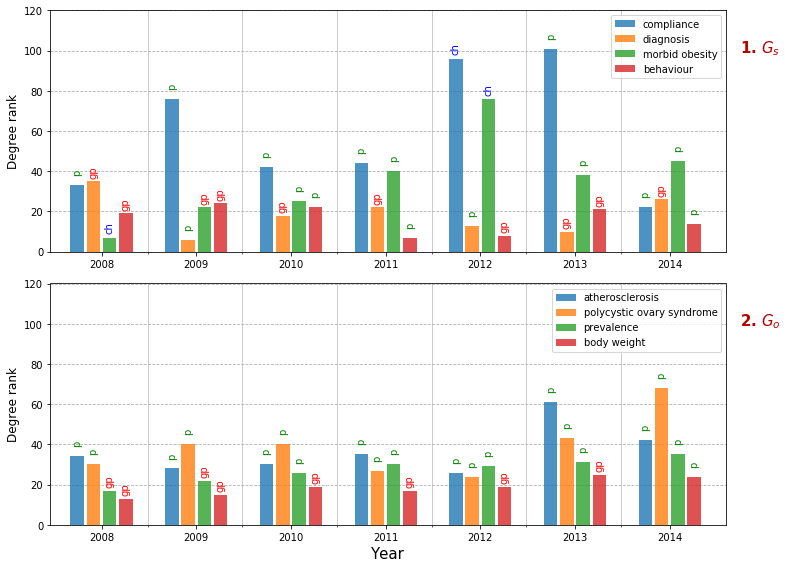

In [245]:
fig, axs = plt.subplots(2,1,figsize=(11,8))
title = ['$G_s$','$G_o$']
col=['r','g','b']
bar_width = 0.50
types={3:'ch',5:'p',20:'gp'}
c={20:'r',5:'g',3:'b',1:'y'}
sp=3.5
xtick=[]
x_ind=np.array([0,sp*1,sp*2,sp*3,sp*4,sp*5,sp*6])
for ind in range(0,2,1):
    ax=axs[ind]
    ax.set_axisbelow(True)
    ax.grid(axis='y', linestyle='--')
    # major_ticks = np.arange(0, 8, .5)
    minor_ticks = np.arange(2.6,21,3.5)

    # ax.set_xticks(major_ticks)
    ax.set_xticks(minor_ticks, minor=True)
    # ax.set_yticks(major_ticks)
    # ax.set_yticks(minor_ticks, minor=True)
    ax.grid(which='minor',linestyle='-', alpha=.8)
    plt.sca(ax)
    plt.ylim(0, 120)
    plt.xlim(-1, 24)
    count = 0
    for name,res in X[domain[ind]].items():
        print(name,res)
        ax.bar(x_ind+count,res[2],bar_width,align='center',alpha=0.8,label=name)
        for num,val in enumerate(res[1]):
            ax.text(x_ind[num]+count, res[2][num]+4,types[val] , color=c[val],horizontalalignment='center',rotation=90)
        count=count+0.6
    plt.title(""+str(ind+1)+". "+title[ind], position=(1.05, .8),fontsize=15,fontweight='bold', color='#b70000')
    xtick=[2008,2009,2010,2011,2012,2013,2014]
    x_pos = np.arange(.9,24,3.5)
    plt.xticks(x_pos, xtick, rotation=0)
    plt.legend(loc='best')
    plt.ylabel('Degree rank', fontsize=12)
plt.xlabel('Year', fontsize=15)
plt.tight_layout()
###save
figpath=root+'dataframes/'
fig_file_name = os.path.join(figpath,'degree_rank'+ ".pdf")
plt.savefig(fig_file_name)
plt.show()

In [130]:
s=np.array([0,7,12,17,22,27])

In [117]:
train_data_a=ut.load_data(root+'dataframes/apnea', 'apnea', "train_data", time)
train_data_o=ut.load_data(root+'dataframes/obesity', 'obesity', "train_data", time)

pos_a=[]
neg_a=[]
pos_o=[]
neg_o=[]
for t in range(2008,2015):
    td_a=train_data_a[t]
    pos_a.extend(td_a[td_a['label']==1]['typeaut'])
    neg_a.extend(td_a[td_a['label']==0]['typeaut'])
    td_o=train_data_o[t]
    pos_o.extend(td_o[td_o['label']==1]['typeaut'])
    neg_o.extend(td_o[td_o['label']==0]['typeaut'])

../linkPrediction/dataframes/apnea
../linkPrediction/dataframes/obesity


In [42]:
ts=time[1]
te=time[2]
domain = '../linkPrediction/dataframes/apnea/'
model =  'apnea'+"-"+str(ts)+"-"+str(te)+"-"+'citation1'
X_file_path = os.path.join(domain,model+"-X"+".pkl")
with open(X_file_path,"rb") as f:
    X_a = pickle.load(f)
y_file_path = os.path.join(domain,model+"-y"+".pkl")
with open(y_file_path,"rb") as f:
    y_a = pickle.load(f)

domain = '../linkPrediction/dataframes/obesity/'
model =  'obesity'+"-"+str(ts)+"-"+str(te)+"-"+'citation1'
X_file_path = os.path.join(domain,model+"-X"+".pkl")
with open(X_file_path,"rb") as f:
    X_o = pickle.load(f)
y_file_path = os.path.join(domain,model+"-y"+".pkl")
with open(y_file_path,"rb") as f:
    y_o = pickle.load(f)

    
domain = '../linkPrediction/dataframes/apnea/'
model =  'apnea'+"-"+str(ts)+"-"+str(te)+"-"+'typeaut'
X_file_path = os.path.join(domain,model+"-X"+".pkl")
with open(X_file_path,"rb") as f:
    xx_a = pickle.load(f)
    xx_a = xx_a / np.linalg.norm(xx_a, ord=np.inf, axis=0, keepdims=True)
y_file_path = os.path.join(domain,model+"-y"+".pkl")
with open(y_file_path,"rb") as f:
    yy_a = pickle.load(f)

domain = '../linkPrediction/dataframes/obesity/'
model =  'obesity'+"-"+str(ts)+"-"+str(te)+"-"+'typeaut'
X_file_path = os.path.join(domain,model+"-X"+".pkl")
with open(X_file_path,"rb") as f:
    xx_o = pickle.load(f)
    xx_o = xx_o / np.linalg.norm(xx_o, ord=np.inf, axis=0, keepdims=True)
y_file_path = os.path.join(domain,model+"-y"+".pkl")
with open(y_file_path,"rb") as f:
    yy_o = pickle.load(f)

In [17]:
ts=2008
te=2015
domain = '../linkPrediction/dataframes/obesity/'
model =  'obesity'+"-"+str(ts)+"-"+str(te)+"-"+'citation1'
X_file_path = os.path.join(domain,model+"-X"+".pkl")
with open(X_file_path,"rb") as f:
    xx_o = pickle.load(f)
   # xx_o = xx_o / np.linalg.norm(xx_o, ord=np.inf, axis=0, keepdims=True)
y_file_path = os.path.join(domain,model+"-y"+".pkl")
with open(y_file_path,"rb") as f:
    yy_o = pickle.load(f)

len(yy_o)

134134

In [43]:
Xn_a=np.array(X_a[y_a==0].flat)
Xp_a=np.array(X_a[y_a==1].flat)
Xn_o=np.array(X_o[y_o==0].flat)
Xp_o=np.array(X_o[y_o==1].flat)

neg_a=np.array(xx_a[yy_a==0].flat)
pos_a=np.array(xx_a[yy_a==1].flat)
neg_o=np.array(xx_o[yy_o==0].flat)
pos_o=np.array(xx_o[yy_o==1].flat)

In [44]:
Xn_a=Xn_a[Xn_a!=0]
Xp_a=Xp_a[Xp_a!=0]
Xn_o=Xn_o[Xn_o!=0]
Xp_o=Xp_o[Xp_o!=0]

neg_a=neg_a[neg_a!=0]
pos_a=pos_a[pos_a!=0]
neg_o=neg_o[neg_o!=0]
pos_o=pos_o[pos_o!=0]

In [45]:
Xp_o

array([0.00054475, 0.00077524, 0.00381319, ..., 0.00118322, 0.00017746,
       0.00216884])

In [46]:
pos_o

array([6.65842290e-04, 1.44133127e-04, 3.79268439e-04, ...,
       5.37690619e-04, 8.29179539e-05, 7.60962618e-04])

C:\Users\faisal\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


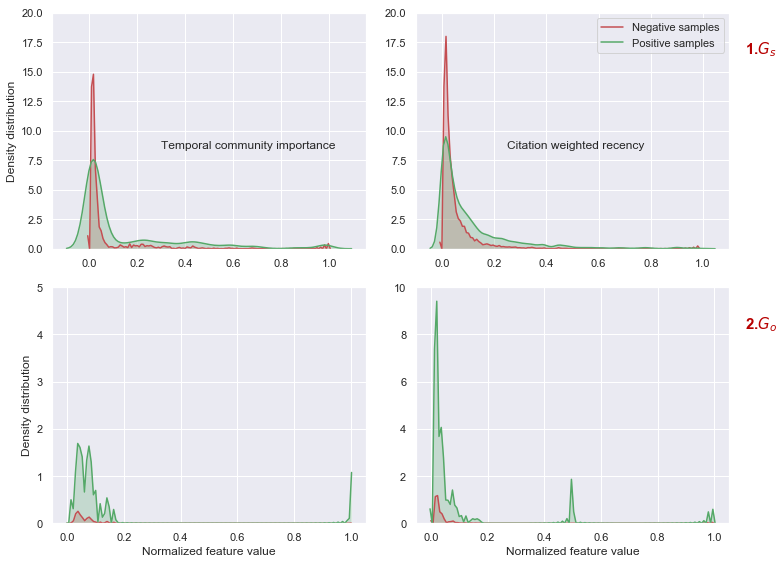

In [159]:
import seaborn as sns; sns.set(color_codes=True)
fig, axs = plt.subplots(2,2,figsize=(11,8))
title = ['$G_s$','$G_o$']
k='gau'
b=0.0001

sns.kdeplot(Xn_a, shade=True, color="r",label='Negative samples', ax=axs[0][1],kernel=k)
sns.kdeplot(Xp_a, shade=True, color="g",label='Positive samples', ax=axs[0][1],kernel=k)
sns.kdeplot(Xn_o, shade=True, color="r", ax=axs[1][1],kernel=k)
sns.kdeplot(Xp_o, shade=True, color="g", ax=axs[1][1],kernel=k)

sns.kdeplot(neg_a, shade=True, color="r", ax=axs[0][0],kernel=k)
sns.kdeplot(pos_a, shade=True, color="g", ax=axs[0][0],kernel=k)
sns.kdeplot(neg_o, shade=True, color="r", ax=axs[1][0],kernel=k)
sns.kdeplot(pos_o, shade=True, color="g", ax=axs[1][0],kernel=k)
axs[0][0].text(.3,8.5,'Temporal community importance')
axs[0][1].text(.25,8.5,'Citation weighted recency')
plt.sca(axs[0][0])
plt.ylim(0,20)
plt.ylabel("Density distribution",fontsize=12)
plt.sca(axs[0][1])
plt.ylim(0,20)
plt.title("1."+title[0], position=(1.1, .8),fontsize=15,fontweight='bold', color='#b70000')
plt.sca(axs[1][0])
plt.ylim(0,5)
plt.ylabel("Density distribution",fontsize=12)
plt.xlabel("Normalized feature value",fontsize=12)
plt.sca(axs[1][1])
plt.ylim(0,10)
plt.xlabel("Normalized feature value",fontsize=12)
plt.title("2."+title[1], position=(1.1, .8),fontsize=15,fontweight='bold', color='#b70000')
plt.tight_layout()
###save
figpath=root+'dataframes/'
fig_file_name = os.path.join(figpath,'distribution'+ ".pdf")
plt.savefig(fig_file_name)
plt.show()

In [39]:
train_data_a=ut.load_data(root+'dataframes/apnea', 'apnea', "train_data", time)
train_data_o=ut.load_data(root+'dataframes/obesity', 'obesity', "train_data", time)
cite=[]
year=[]
for t in range(2008,2015):
    temp1 = train_data[t][(train_data[t]['label']==1)]['citation1']
    temp2 = [t]*len(temp1)
    cite.extend(temp1)
    year.extend(temp2)

../linkPrediction/dataframes/apnea
../linkPrediction/dataframes/obesity


../linkPrediction/dataframes/apnea
../linkPrediction/dataframes/obesity


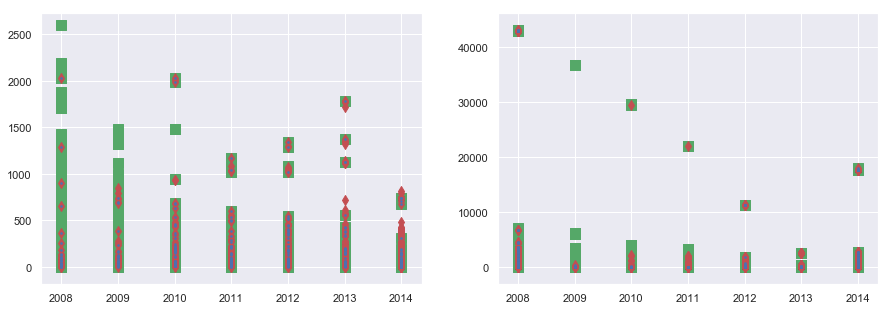

In [258]:
fig, axs = plt.subplots(1,2,figsize=(15,5))
title = ['$G_s$','$G_o$']
col=['r','g','b']
markers=['s','d','.']
size=[100,50,10]
ind=0
cite_fast,year_fast,cite_last,year_last,cite_un,year_un = citt(ind)
axs[ind].scatter(year_fast,cite_fast,c=col[1],marker=markers[0],s=size[0])
axs[ind].scatter(year_last,cite_last,c=col[0],marker=markers[1],s=size[1])
axs[ind].scatter(year_un,cite_un,c=col[2],marker=markers[2],s=size[2])

ind=1
cite_fast,year_fast,cite_last,year_last,cite_un,year_un = citt(ind)
axs[ind].scatter(year_fast,cite_fast,c=col[1],marker=markers[0],s=size[0])
axs[ind].scatter(year_last,cite_last,c=col[0],marker=markers[1],s=size[1])
axs[ind].scatter(year_un,cite_un,c=col[2],marker=markers[2],s=size[2])

In [ ]:
cite_fast,year_fast,cite_last,year_last,cite_un,year_un = citt(0)

In [5]:
def citt(ind):
    doms=['apnea','obesity']
    dom=doms[ind]
    path=root+'dataframes/'+dom
    train_data=ut.load_data(path, dom, "train_data", time)
    #train_data=ut.load_data(root+'dataframes/obesity', 'obesity', "train_data", time)
    last_year=[]
    cite_last = []
    year_last=[]
    old=set()
    for t in range(2014,2007,-1):
        data=train_data[t]
        present = set(data[(data['label']==1)]['row_name'])
        new=present.difference(old)
#         print(len(new),len(present))
        old.update(present)
        last_year.extend(new)
        data1 = data.loc[data['row_name'].isin(new)]['citation1']
        tt=[t]*len(data1)
        cite_last.extend(list(data1))
        year_last.extend(tt)
#     print('---------------------')
    fast_year=[]
    cite_fast = []
    year_fast=[]
    old=set()
    for t in range(2008,2015,1):
        data=train_data[t]
        present = set(data[(data['label']==1)]['row_name'])
        new=present.difference(old)
#         print(len(new),len(present))
        old.update(present)
        fast_year.extend(new)
        data1 = data.loc[data['row_name'].isin(new)]['citation1']
        tt=[t]*len(data1)
        cite_fast.extend(list(data1))
        year_fast.extend(tt)
        
    cite_un=[]
    year_un=[]
    for t in range(2008,2015,1):
        present = set(train_data[t][(train_data[t]['label']==1)]['row_name'])
        other = set()
        for tt in range(2008,2015,1):
            if tt!=t:
                temp = set(train_data[tt][(train_data[tt]['label']==1)]['row_name'])
                other.update(temp)
        unique=present.difference(other)
        data2=train_data[t].loc[train_data[t]['row_name'].isin(unique)]['citation1']
        cite_un.extend(list(data2))
        yy=[t]*len(data2)
        year_un.extend(yy)
        
    return cite_fast,year_fast,cite_last,year_last,cite_un,year_un

In [237]:
ind=1
cite_fast,year_fast,cite_last,year_last,cite_un,year_un = citt(ind)

../linkPrediction/dataframes/obesity


In [238]:
len(cite_un)

3202

In [6]:
import numpy as np; np.random.seed(0)
import seaborn as sns; sns.set()
uniform_data = np.random.rand(10, 12)

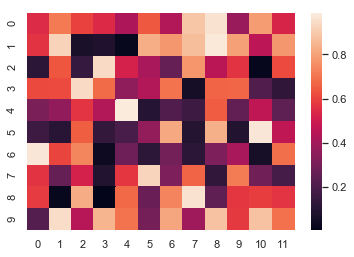

In [10]:
ax = sns.heatmap(uniform_data)

In [7]:
domain = ['apnea','obesity']
datapath = '../linkPrediction/dataframes/apnea'
select_domain = 0
node_a = ut.load_data(datapath, domain[select_domain], "test_node", time)

datapath = '../linkPrediction/dataframes/obesity'
select_domain = 1
node_o = ut.load_data(datapath, domain[select_domain], "test_node", time)

../linkPrediction/dataframes/apnea
../linkPrediction/dataframes/obesity


In [109]:
from sklearn.preprocessing import minmax_scale
aut_a = np.asarray(node_a[2015]['term_aut'])
aut_a = minmax_scale(aut_a, feature_range=(0,1), axis=0)
aut_type_a = np.asarray(node_a[2015]['node_type_aut'])
aut_o = np.asarray(node_o[2015]['term_aut'])
aut_o = minmax_scale(aut_o, feature_range=(0,1), axis=0)
aut_type_o = np.asarray(node_o[2015]['node_type_aut'])
deg_a = np.asarray(node_a[2015]['degree'])
deg_a = minmax_scale(deg_a, feature_range=(0,1), axis=0)
deg_type_a = np.asarray(node_a[2015]['node_type_deg'])
deg_o = np.asarray(node_o[2015]['degree'])
deg_o = minmax_scale(deg_o, feature_range=(0,1), axis=0)
deg_type_o = np.asarray(node_o[2015]['node_type_deg'])

C:\Users\faisal\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64.
  warnings.warn(msg, DataConversionWarning)
C:\Users\faisal\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64.
  warnings.warn(msg, DataConversionWarning)


array([0.52853186, 0.7802644 , 0.71340001, ..., 0.50594489, 0.43774164,
       0.43774164])

In [111]:
aca=aut_a[aut_type_a==3]
apa=aut_a[aut_type_a==5]
agpa=aut_a[aut_type_a==20]
aga=aut_a[aut_type_a==1]
dca=deg_a[deg_type_a==3]
dpa=deg_a[deg_type_a==5]
dgpa=deg_a[deg_type_a==20]
dga=deg_a[deg_type_a==1]

aco=aut_o[aut_type_o==3]
apo=aut_o[aut_type_o==5]
agpo=aut_o[aut_type_o==20]
ago=aut_o[aut_type_o==1]
dco=deg_o[deg_type_o==3]
dpo=deg_o[deg_type_o==5]
dgpo=deg_o[deg_type_o==20]
dgo=deg_o[deg_type_o==1]

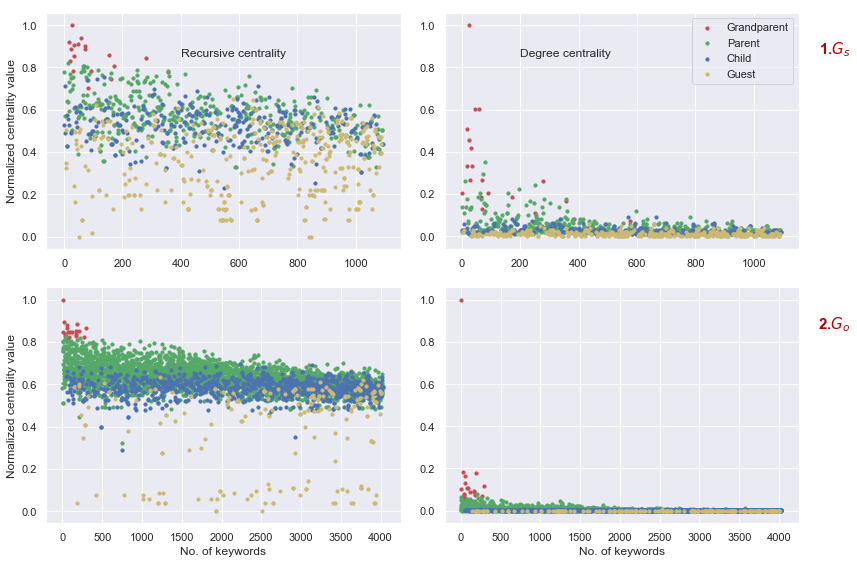

In [157]:
fig, axs = plt.subplots(2,2,figsize=(12,8))
title = ['$G_s$','$G_o$']
col=['r','g','b','y']
ax=axs[0][0]
plt.sca(ax)
ax.scatter(np.where(aut_type_a==20),agpa,c=col[0],s=10)
ax.scatter(np.where(aut_type_a==5),apa,c=col[1],s=10)
ax.scatter(np.where(aut_type_a==3),aca,c=col[2],s=10)
ax.scatter(np.where(aut_type_a==1),aga,c=col[3],s=10)
plt.ylabel("Normalized centrality value",fontsize=12)

ax=axs[0][1]
plt.sca(ax)
ax.scatter(np.where(deg_type_a==20),dgpa,c=col[0],label='Grandparent',s=10)
ax.scatter(np.where(deg_type_a==5),dpa,c=col[1],label='Parent',s=10)
ax.scatter(np.where(deg_type_a==3),dca,c=col[2],label='Child',s=10)
ax.scatter(np.where(deg_type_a==1),dga,c=col[3],label='Guest',s=10)
plt.legend(loc='best')

axs[0][0].text(400,.85,'Recursive centrality')
axs[0][1].text(200,.85,'Degree centrality')
plt.title("1."+title[0], position=(1.1, .8),fontsize=15,fontweight='bold', color='#b70000')

ax=axs[1][0]
plt.sca(ax)
ax.scatter(np.where(aut_type_o==20),agpo,c=col[0],s=10)
ax.scatter(np.where(aut_type_o==5),apo,c=col[1],s=10)
ax.scatter(np.where(aut_type_o==3),aco,c=col[2],s=10)
ax.scatter(np.where(aut_type_o==1),ago,c=col[3],s=10)
plt.ylabel("Normalized centrality value",fontsize=12)
plt.xlabel("No. of keywords",fontsize=12)

ax=axs[1][1]
plt.sca(ax)
ax.scatter(np.where(deg_type_o==20),dgpo,c=col[0],s=10)
ax.scatter(np.where(deg_type_o==5),dpo,c=col[1],s=10)
ax.scatter(np.where(deg_type_o==3),dco,c=col[2],s=10)
ax.scatter(np.where(deg_type_o==1),dgo,c=col[3],s=10)
plt.xlabel("No. of keywords",fontsize=12)
plt.title("2."+title[1], position=(1.1, .8),fontsize=15,fontweight='bold', color='#b70000')

plt.tight_layout()
###save
figpath=root+'dataframes/'
fig_file_name = os.path.join(figpath,'variance'+ ".pdf")
plt.savefig(fig_file_name)
plt.show()

In [10]:
import pandas as pd
import pickle
import os.path

In [285]:
unpickled_df = pd.read_pickle("final_FF_1.pkl")

ModuleNotFoundError: No module named 'pandas.core.internals.managers'; 'pandas.core.internals' is not a package